# Modules

In [ ]:
import os
import numpy as np
import cv2
import glob
import pandas as pd
import random as rn

import seaborn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet201
from sklearn.metrics import confusion_matrix
from statistics import stdev

In [ ]:
print(tf.__version__)

2.6.0


# Data processing

In [ ]:
# Chemin du dossier chest_xray
global_path = "./drive/MyDrive/chest_xray/"
os.listdir(global_path)

# Chemin des dossiers normal/pneumonie pour le jeu test et train
train_normal_path = global_path + 'train/NORMAL/'
train_pneu_path = global_path + 'train/PNEUMONIA/'

test_normal_path = global_path + 'test/NORMAL/'
test_pneu_path = global_path + 'test/PNEUMONIA/'

train_normal_img = glob.glob(train_normal_path + '*jpeg')
train_pneu_img = glob.glob(train_pneu_path + '*jpeg')

test_normal_img = glob.glob(test_normal_path + '*jpeg')
test_pneu_img = glob.glob(test_pneu_path + '*jpeg')

# Création de liste contenant les images et la classe de chaque image
train_list = []
test_list = []

for x in train_normal_cases:
    train_list.append([x, 0])
    
for x in train_pneu_cases:
    train_list.append([x, 1])
    
for x in test_normal_cases:
    test_list.append([x, 0])
    
for x in test_pneu_cases:
    test_list.append([x, 1])

rn.shuffle(train_list)
rn.shuffle(test_list)

# Création de dataframe
train_df = pd.DataFrame(train_list, columns=['image', 'label'])
test_df = pd.DataFrame(test_list, columns=['image', 'label'])

In [ ]:
# Countplot des jeux de données
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
seaborn.countplot(train_df['label'])
plt.title('Train data')

plt.subplot(1,3,2)
seaborn.countplot(test_df['label'])
plt.title('Test data')

plt.show()

In [ ]:
def process_data(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150, 150))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (150,150,1))
    
    return img

def build_dataset(df):
    data = []
    labels = []

    for img_path, label in df.values:
        data.append(process_data(img_path))
        labels.append(label)
        
    return np.array(data), np.array(labels)

In [ ]:
X_train, y_train = build_dataset(train_df)
X_test, y_test = build_dataset(test_df)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))

In [ ]:
%cd drive
%cd MyDrive/
%cd data_npz/
!ls

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data_npz
xray_test.npz  xray_train.npz


In [ ]:
%cp xray_test.npz /content/
%cp xray_train.npz /content/

In [ ]:
%cd /content/

/content


In [ ]:
# Sauvegarde des jeux de données

np.savez("xray_train.npz",X_train = X_train, y_train = y_train)
np.savez("xray_test.npz", X_test = X_test, y_test = y_test)

In [ ]:
# A décommenter quand on utilise les fichiers npz

train_file = "xray_train.npz"
data_train = np.load(train_file)
X_train = data_train["X_train"]
y_train = data_train["y_train"]
X_train = X_train.astype("float32")

test_file = "xray_test.npz"
data_test = np.load(test_file)
X_test = data_test["X_test"]
y_test = data_test["y_test"]
X_test = X_test.astype("float32")

# CNN

Pour toute cette partie on restera sur 10 époques, car des tests précédent réaliser sur un nombre plus important d'époques sans et avec early stopping nous a montrer que l'apprentissage dépasse rarement les 10 époques et de façon plus large ne dépasse pas les 12-14 époques.

## Initialisation des poids

De part le léger déséquilbre entre les classes dans les jeux de données nous avons décidé d'initialiser les poids.

Les valeurs des poids initiales ont été choisi par des test préalablement réalisé sur un réseau CNN très simple

weight_0 = $\frac {1}{n_{normal}} \times \frac {n_{total}}{2}$

weight_1 = $\frac {1}{n_{pneumonie}} \times \frac {n_{total}}{2}$

In [ ]:
w0 = (1/(len(y_train) - np.count_nonzero(y_train))) * (len(y_train)/2)
w1 = (1/(np.count_nonzero(y_train))) * (len(y_train)/2)

cl_weights = {0: w0,
        1: w1}

## test des paramètre de la data Augmentation

Le réseau utilisé pour ces tests est un réseau obtenu après avoir effectué différents au préalable en s'inspirant de réseau provenant de notebook sur kaggle.

Nous en avons conclu qu'un modèle simple avec relativement peu de paramètres serait amplement suffisant.

In [ ]:
def block_conv(input, filters):
  x = layers.Conv2D(filters, 3, activation='relu')(input)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(2)(x)
  return(x)

In [ ]:
inputs = layers.Input(shape=(150, 150, 1 ))

bc1 = block_conv(inputs, 16)

bc2 = block_conv(bc1, 32)

bc3 = block_conv(bc2, 64)

bc4 = block_conv(bc3, 128)

flat_1 = layers.Flatten()(bc4)
dense_1 = layers.Dense(32)(flat_1)
drop_1 = layers.Dropout(0.2)(dense_1)
outputs = layers.Dense(1, activation='sigmoid')(drop_1)

CNN_model = keras.Model(inputs, outputs)

print(CNN_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      160       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0     

### Sans data augmentation

In [ ]:
datagen_sd = ImageDataGenerator(
    validation_split = 0.1
)

Affichage de 3 images non modifiées

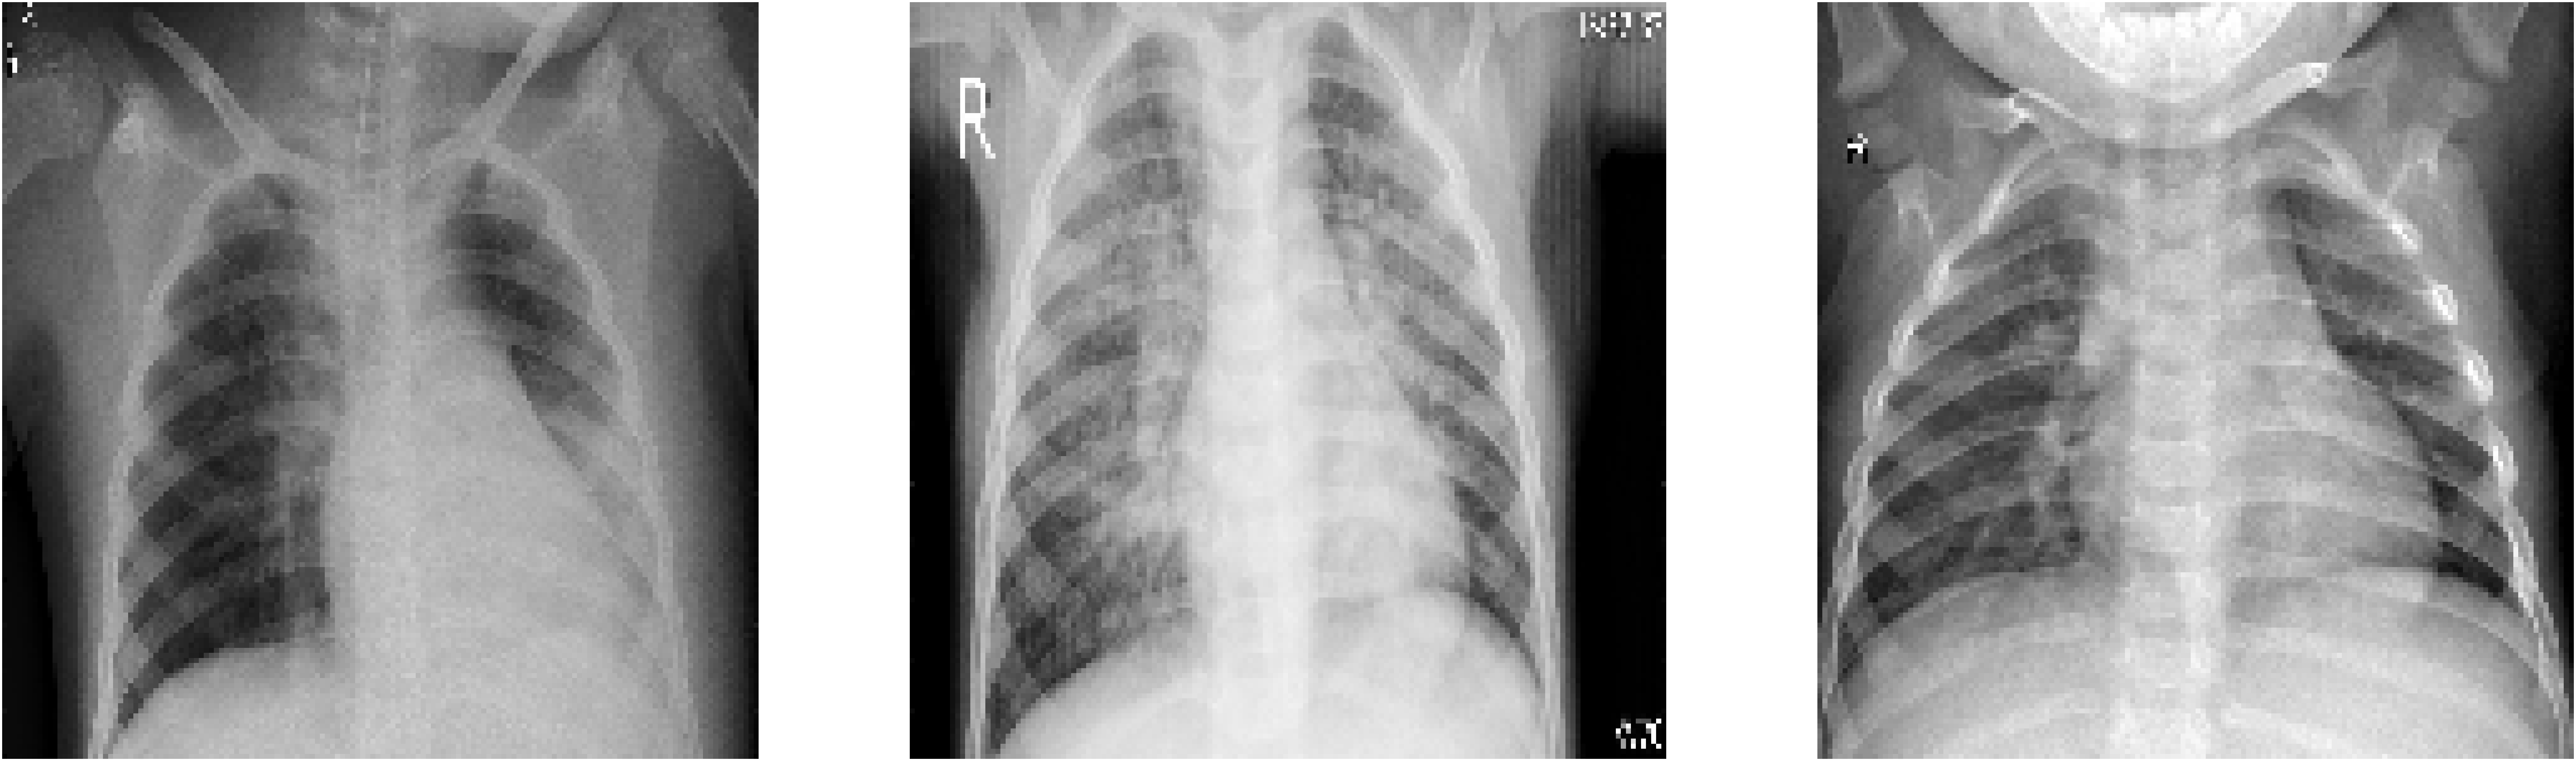

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_sd.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_CNN = CNN_model.fit(
    datagen_sd.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_sd.flow(X_train, y_train, subset="validation")
)

test_sd = CNN_model.evaluate(X_test, y_test)
print(test_sd)

Epoch 1/10
148/148 [==============================] - 7s 38ms/step - loss: 0.5696 - accuracy: 0.9195 - val_loss: 5.8416 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 5s 36ms/step - loss: 0.2787 - accuracy: 0.9556 - val_loss: 4.7262 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 5s 36ms/step - loss: 0.1934 - accuracy: 0.9645 - val_loss: 1.5073 - val_accuracy: 0.8103
Epoch 4/10
148/148 [==============================] - 5s 36ms/step - loss: 0.1929 - accuracy: 0.9645 - val_loss: 0.5156 - val_accuracy: 0.9464
Epoch 5/10
148/148 [==============================] - 5s 36ms/step - loss: 0.0961 - accuracy: 0.9817 - val_loss: 0.1592 - val_accuracy: 0.9808
Epoch 6/10
148/148 [==============================] - 5s 36ms/step - loss: 0.0728 - accuracy: 0.9813 - val_loss: 0.8775 - val_accuracy: 0.9023
Epoch 7/10
148/148 [==============================] - 5s 36ms/step - loss: 0.0578 - accuracy: 0.9851 - val_loss: 0.2111 - val_accuracy: 0.9636

Surapprentisage

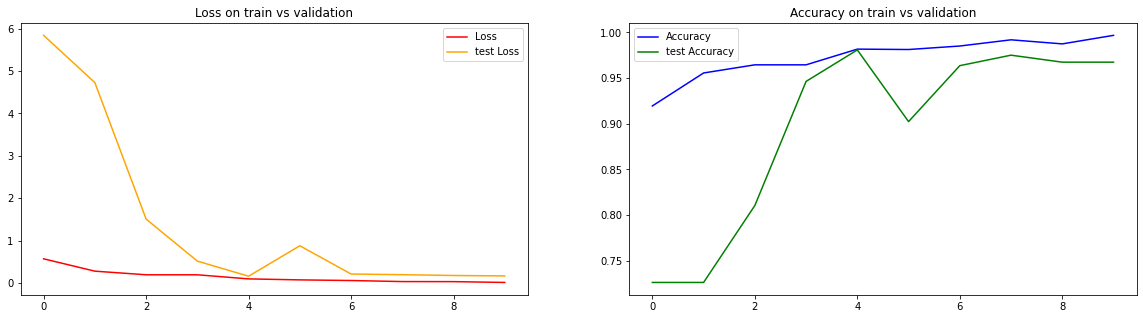

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_CNN.epoch, y=history_CNN.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_CNN.epoch, y=history_CNN.history['val_loss'], color='orange', label='test Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_CNN.epoch, y=history_CNN.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_CNN.epoch, y=history_CNN.history['val_accuracy'], color='green', label='test Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

### Rotation

In [ ]:
datagen_r = ImageDataGenerator(
    validation_split = 0.1,
    rotation_range = 10
)

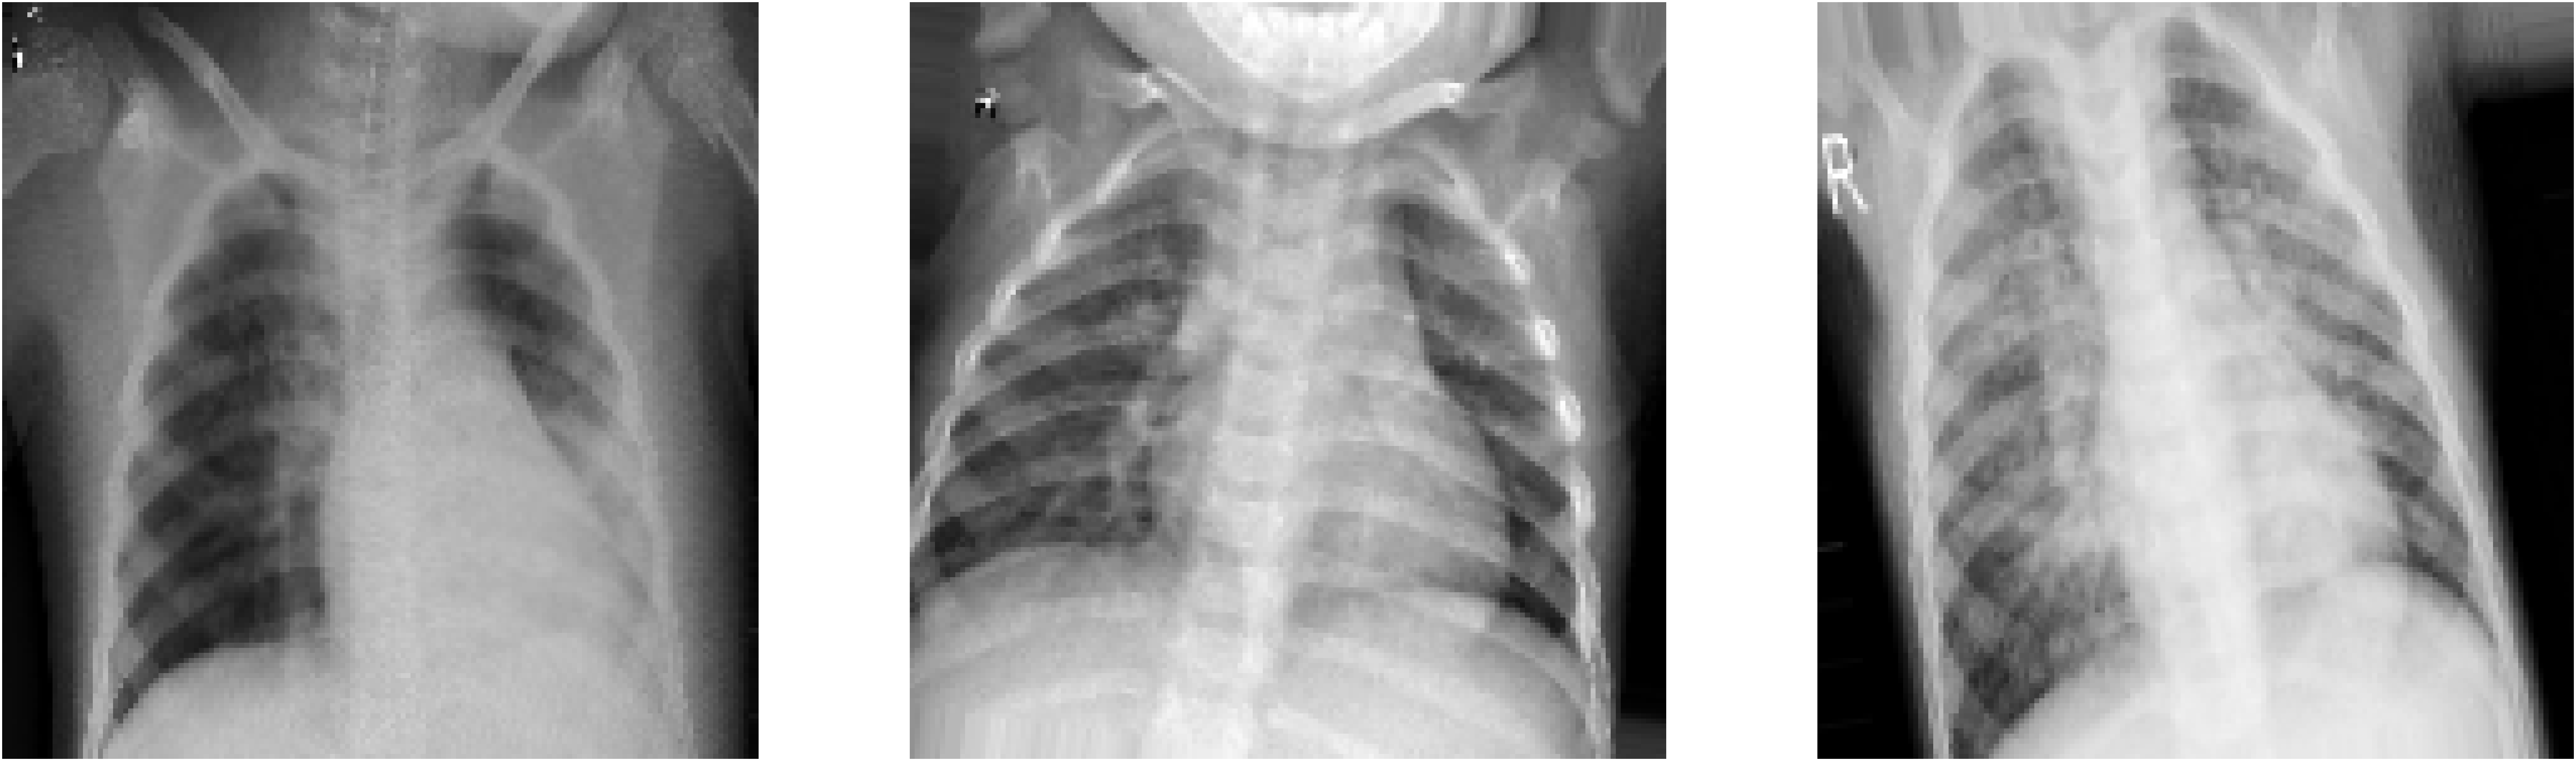

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_r.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

ne pas oublier de relancer la cellule de création du modèle

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_r = CNN_model.fit(
    datagen_r.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_r.flow(X_train, y_train, subset="validation")
)

test_r = CNN_model.evaluate(X_test, y_test)
print(test_r)

Epoch 1/10
148/148 [==============================] - 14s 87ms/step - loss: 0.7837 - accuracy: 0.9048 - val_loss: 2.1457 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 85ms/step - loss: 0.3022 - accuracy: 0.9399 - val_loss: 3.2581 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 12s 84ms/step - loss: 0.2770 - accuracy: 0.9484 - val_loss: 4.1718 - val_accuracy: 0.7299
Epoch 4/10
148/148 [==============================] - 12s 84ms/step - loss: 0.2586 - accuracy: 0.9465 - val_loss: 0.8621 - val_accuracy: 0.8985
Epoch 5/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1519 - accuracy: 0.9611 - val_loss: 0.4853 - val_accuracy: 0.8659
Epoch 6/10
148/148 [==============================] - 12s 84ms/step - loss: 0.1115 - accuracy: 0.9673 - val_loss: 1.0799 - val_accuracy: 0.8851
Epoch 7/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1383 - accuracy: 0.9649 - val_loss: 0.5704 - val_accuracy:

La rotation améliore les performance du modèle

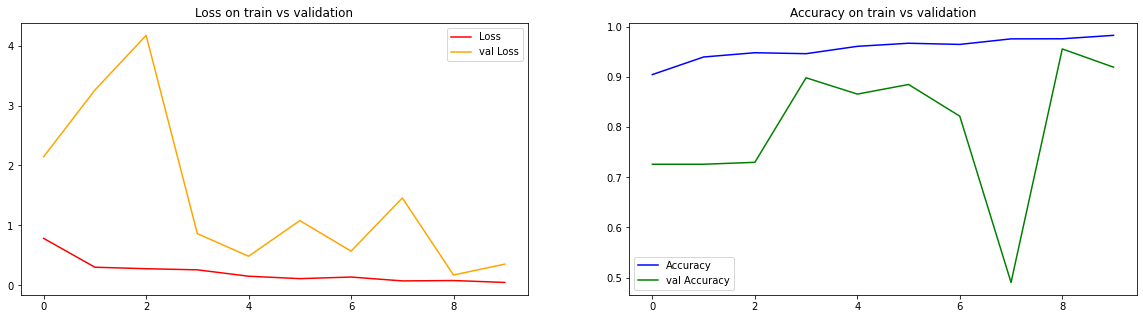

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_r.epoch, y=history_r.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_r.epoch, y=history_r.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_r.epoch, y=history_r.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_r.epoch, y=history_r.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

### Shift

In [ ]:
datagen_sh = ImageDataGenerator(
    validation_split = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

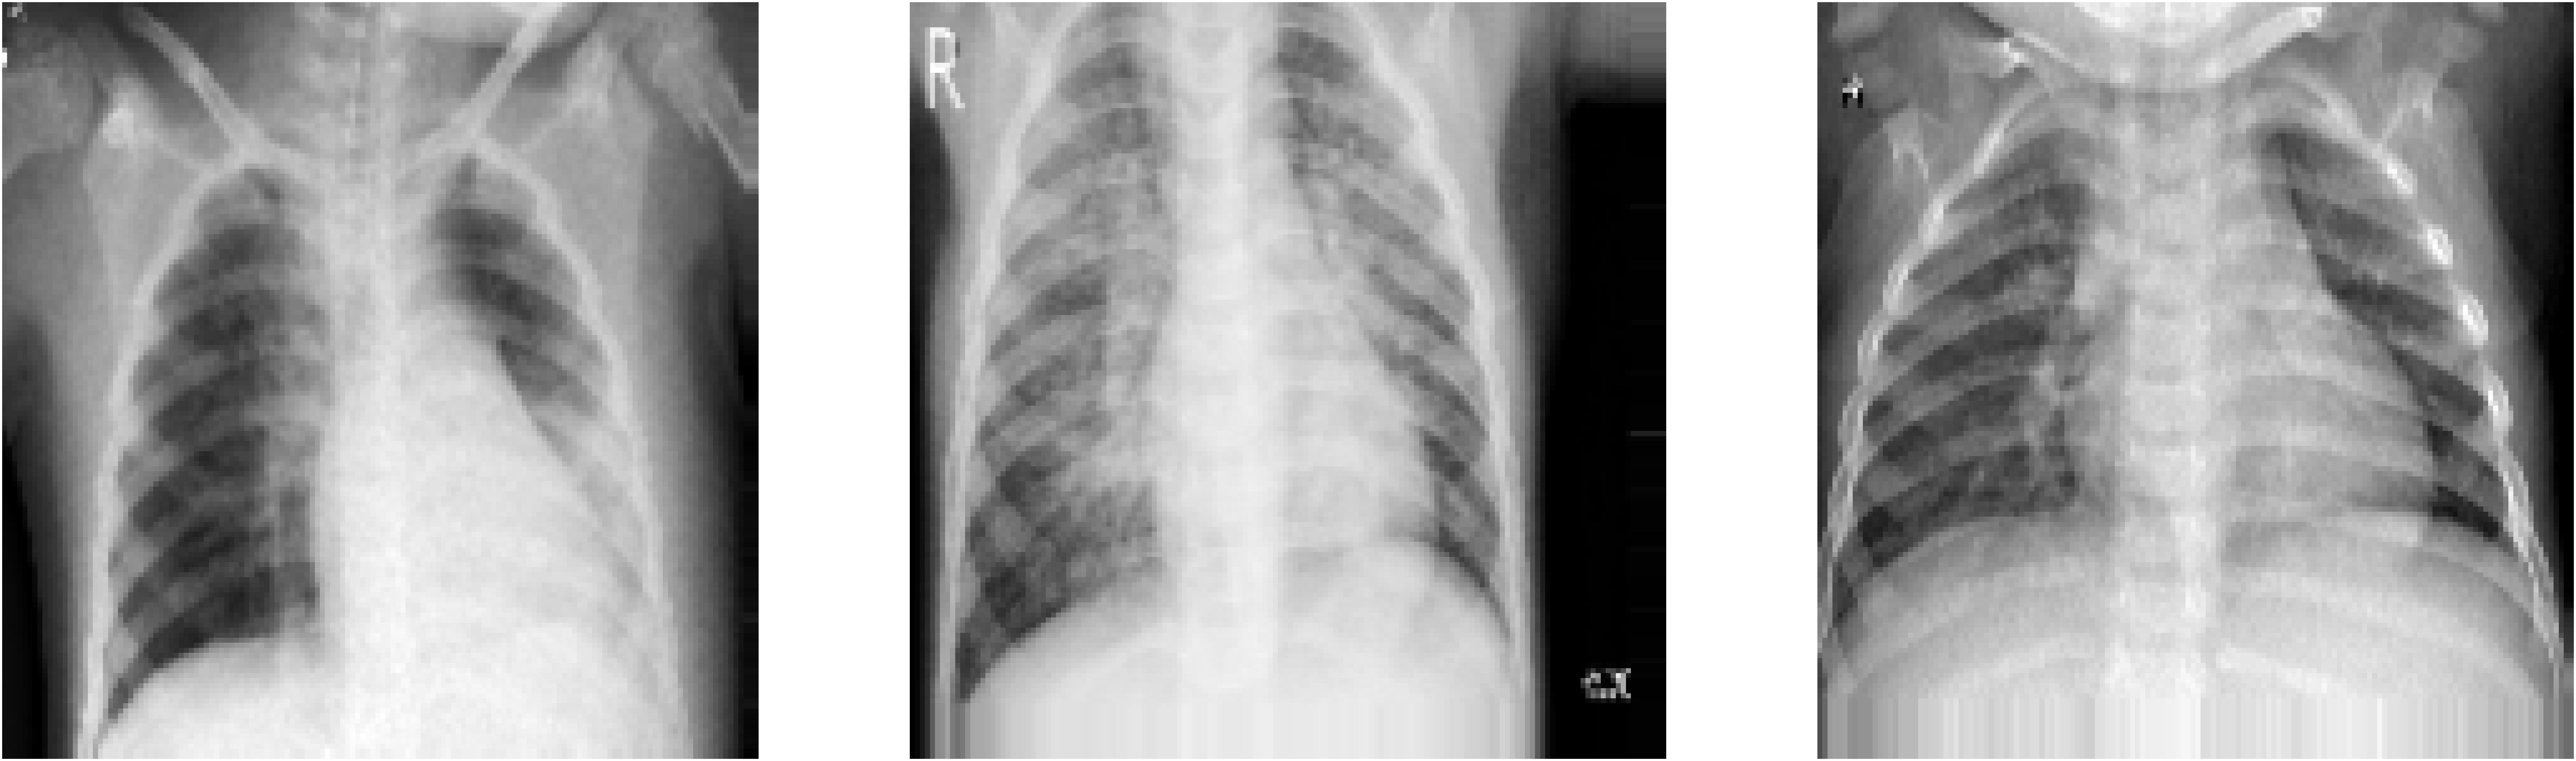

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_sh.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_sh = CNN_model.fit(
    datagen_r.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_sh.flow(X_train, y_train, subset="validation")
)

test_sh = CNN_model.evaluate(X_test, y_test)
print(test_sh)

Epoch 1/10
148/148 [==============================] - 14s 87ms/step - loss: 0.7800 - accuracy: 0.8976 - val_loss: 2.7740 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 85ms/step - loss: 0.3266 - accuracy: 0.9382 - val_loss: 3.5159 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 12s 84ms/step - loss: 0.1672 - accuracy: 0.9571 - val_loss: 1.6407 - val_accuracy: 0.7720
Epoch 4/10
148/148 [==============================] - 12s 83ms/step - loss: 0.2428 - accuracy: 0.9488 - val_loss: 0.6737 - val_accuracy: 0.8870
Epoch 5/10
148/148 [==============================] - 12s 83ms/step - loss: 0.1134 - accuracy: 0.9654 - val_loss: 0.2621 - val_accuracy: 0.9253
Epoch 6/10
148/148 [==============================] - 12s 83ms/step - loss: 0.1231 - accuracy: 0.9615 - val_loss: 0.4341 - val_accuracy: 0.8870
Epoch 7/10
148/148 [==============================] - 12s 82ms/step - loss: 0.0866 - accuracy: 0.9707 - val_loss: 0.2768 - val_accuracy:

le shift n'apporte rien la valeur est quasi identique avec sans data augmatation

### Zoom

In [ ]:
datagen_z = ImageDataGenerator(
    zoom_range = 0.1,
    validation_split = 0.1 
)

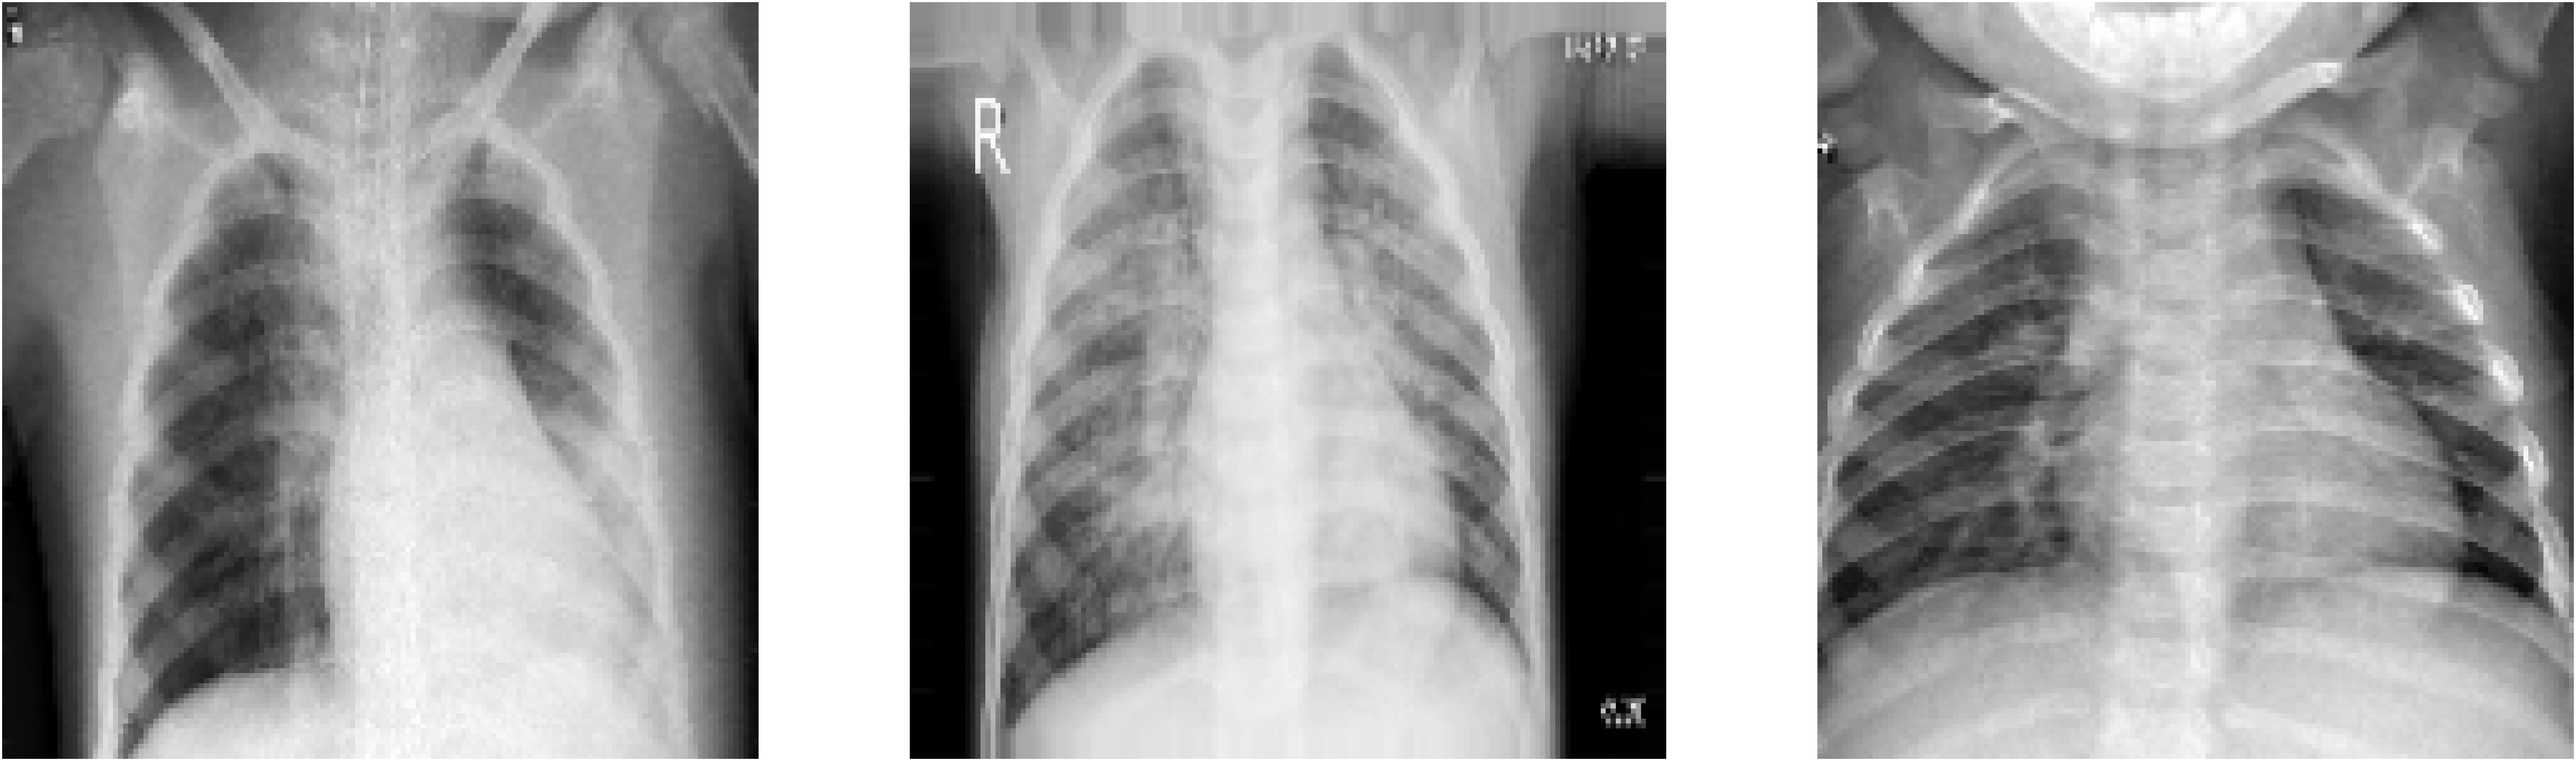

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_z.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_z = CNN_model.fit(
    datagen_z.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_z.flow(X_train, y_train, subset="validation")
)

test_z = CNN_model.evaluate(X_test, y_test)
print(test_z)

Epoch 1/10
148/148 [==============================] - 14s 87ms/step - loss: 0.8336 - accuracy: 0.8912 - val_loss: 7.3923 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 85ms/step - loss: 0.2659 - accuracy: 0.9428 - val_loss: 4.0745 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 85ms/step - loss: 0.3420 - accuracy: 0.9320 - val_loss: 0.4151 - val_accuracy: 0.8831
Epoch 4/10
148/148 [==============================] - 13s 85ms/step - loss: 0.2263 - accuracy: 0.9407 - val_loss: 0.5522 - val_accuracy: 0.8908
Epoch 5/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1725 - accuracy: 0.9499 - val_loss: 0.3425 - val_accuracy: 0.8851
Epoch 6/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1259 - accuracy: 0.9592 - val_loss: 0.3853 - val_accuracy: 0.9272
Epoch 7/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1178 - accuracy: 0.9609 - val_loss: 0.1406 - val_accuracy:

L'ajout d'un zoom aléatoirement améliore nettement les perfomances du modèle.

Au moment où nous écrivons ces lignes, nous avons obtenu 90% d'accuracy sur le jeu de test, c'est la première que l'accuracy est si élevé uniquement avec un zoom pour la data augmentation. Les valeurs sont plus habituellement autour de 86%.

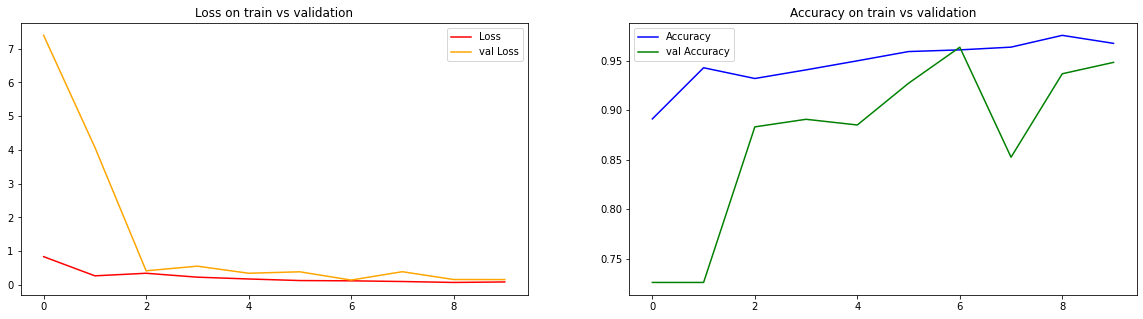

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_z.epoch, y=history_z.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_z.epoch, y=history_z.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_z.epoch, y=history_z.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_z.epoch, y=history_z.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

### Brightness_range

In [ ]:
datagen_br = ImageDataGenerator(
    brightness_range = [0.5,1.5],
    validation_split = 0.1 
)

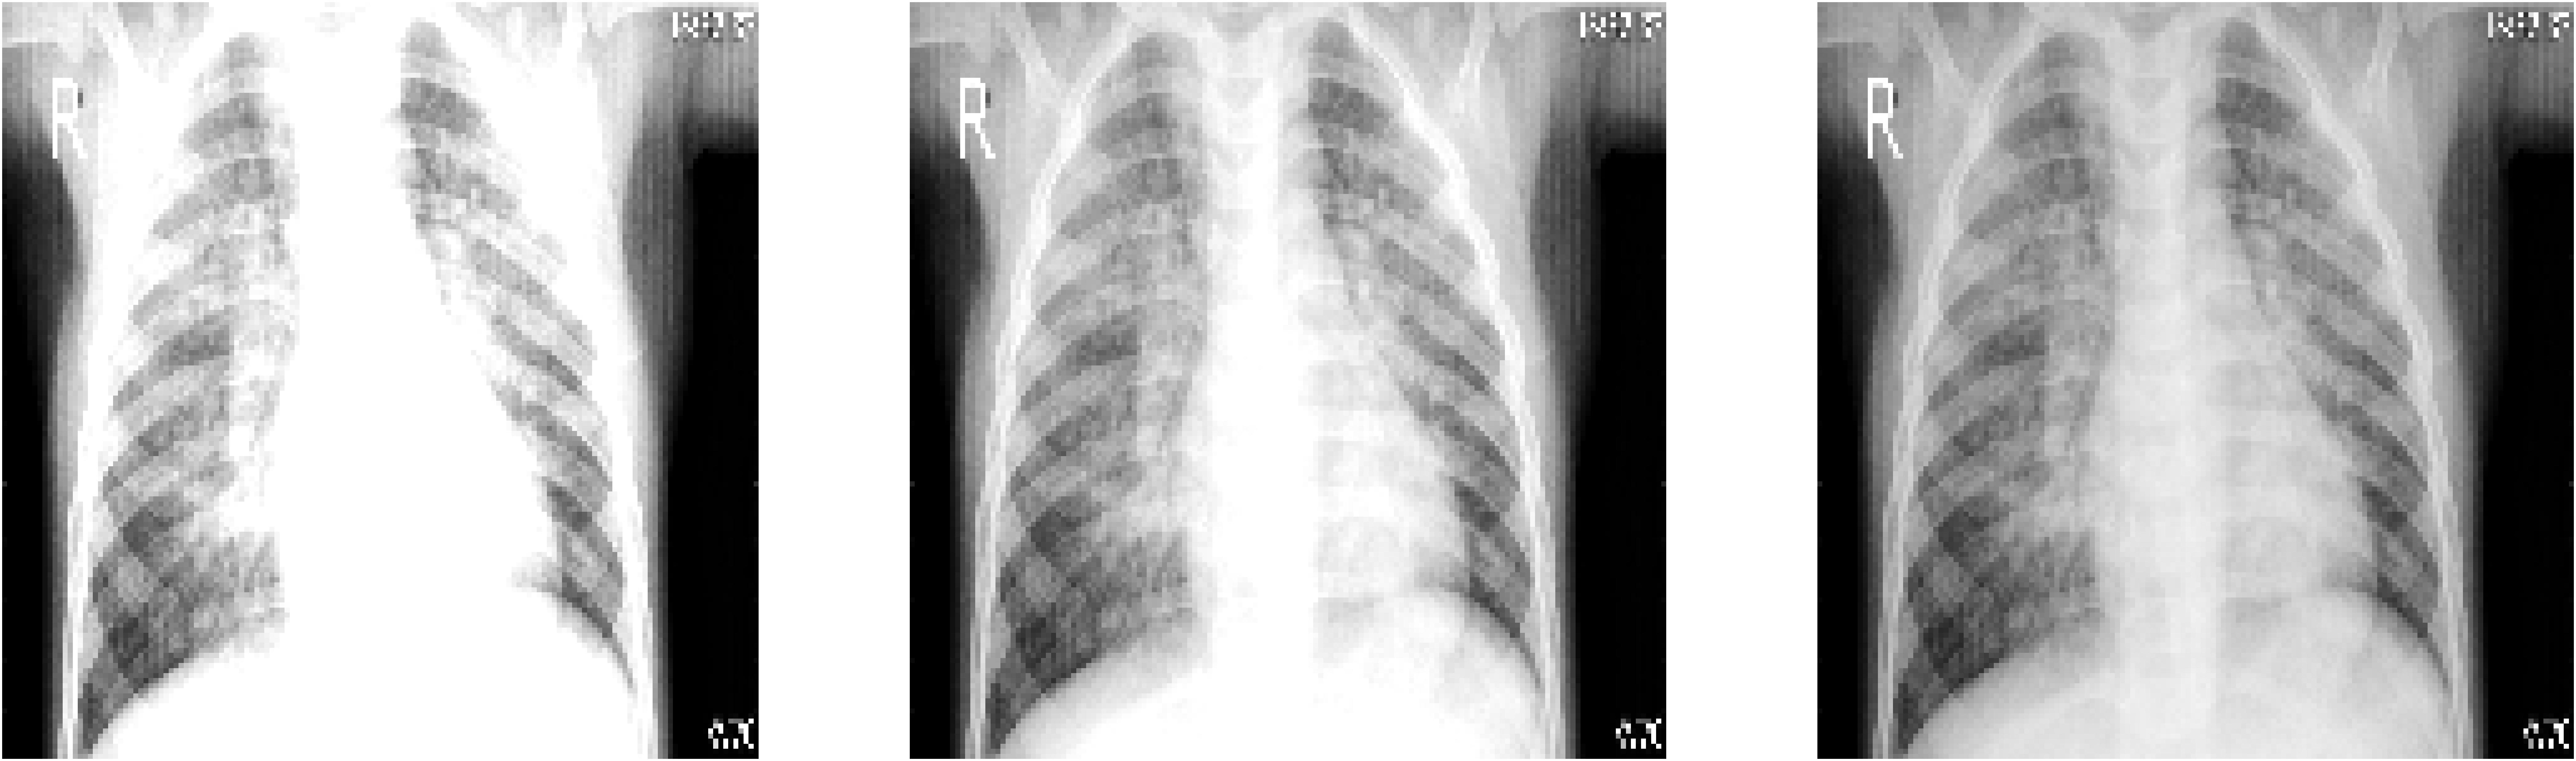

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_br.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_br = CNN_model.fit(
    datagen_br.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_br.flow(X_train, y_train, subset="validation")
)

test_br = CNN_model.evaluate(X_test, y_test)
print(test_br)

Epoch 1/10
148/148 [==============================] - 37s 41ms/step - loss: 0.6598 - accuracy: 0.8942 - val_loss: 0.2513 - val_accuracy: 0.9464
Epoch 2/10
148/148 [==============================] - 6s 38ms/step - loss: 0.3481 - accuracy: 0.9382 - val_loss: 0.1582 - val_accuracy: 0.9464
Epoch 3/10
148/148 [==============================] - 5s 37ms/step - loss: 0.2114 - accuracy: 0.9537 - val_loss: 0.1258 - val_accuracy: 0.9540
Epoch 4/10
148/148 [==============================] - 5s 37ms/step - loss: 0.1011 - accuracy: 0.9690 - val_loss: 0.3418 - val_accuracy: 0.9310
Epoch 5/10
148/148 [==============================] - 6s 37ms/step - loss: 0.0897 - accuracy: 0.9724 - val_loss: 0.3279 - val_accuracy: 0.9176
Epoch 6/10
148/148 [==============================] - 5s 37ms/step - loss: 0.0520 - accuracy: 0.9836 - val_loss: 0.1786 - val_accuracy: 0.9598
Epoch 7/10
148/148 [==============================] - 5s 37ms/step - loss: 0.0318 - accuracy: 0.9881 - val_loss: 0.2095 - val_accuracy: 0.954

NUL

### Shear range

In [ ]:
datagen_sr = ImageDataGenerator(
    shear_range = 10,
    validation_split = 0.1 
)

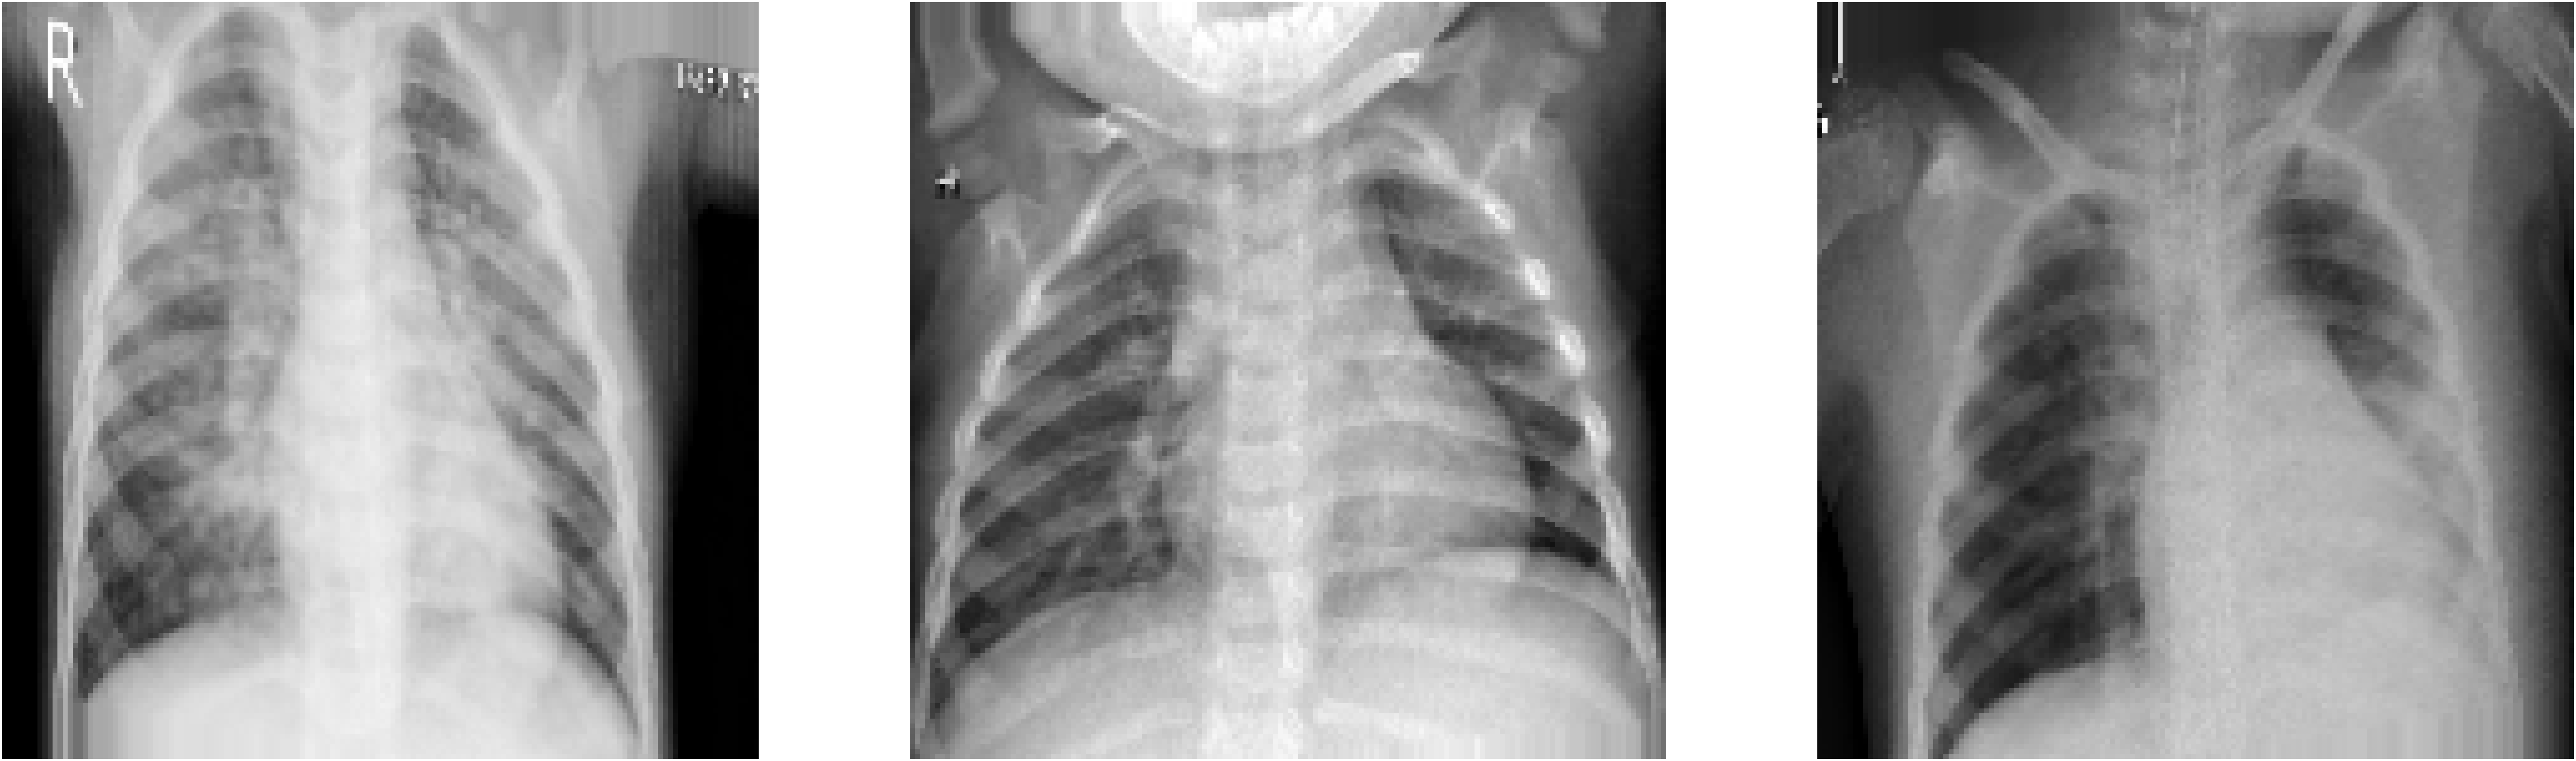

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_sr.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_sr = CNN_model.fit(
    datagen_sr.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_sr.flow(X_train, y_train, subset="validation")
)

test_sr = CNN_model.evaluate(X_test, y_test)
print(test_sr)

Epoch 1/10
148/148 [==============================] - 14s 86ms/step - loss: 0.7292 - accuracy: 0.9065 - val_loss: 1.4207 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 12s 84ms/step - loss: 0.3441 - accuracy: 0.9407 - val_loss: 4.4662 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 85ms/step - loss: 0.2756 - accuracy: 0.9522 - val_loss: 4.4785 - val_accuracy: 0.7299
Epoch 4/10
148/148 [==============================] - 13s 85ms/step - loss: 0.2026 - accuracy: 0.9592 - val_loss: 0.2389 - val_accuracy: 0.9674
Epoch 5/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1271 - accuracy: 0.9698 - val_loss: 0.2443 - val_accuracy: 0.9483
Epoch 6/10
148/148 [==============================] - 12s 84ms/step - loss: 0.1320 - accuracy: 0.9662 - val_loss: 0.2289 - val_accuracy: 0.9579
Epoch 7/10
148/148 [==============================] - 12s 84ms/step - loss: 0.0829 - accuracy: 0.9771 - val_loss: 0.1911 - val_accuracy:

Le shear range augment également les performances du modèle

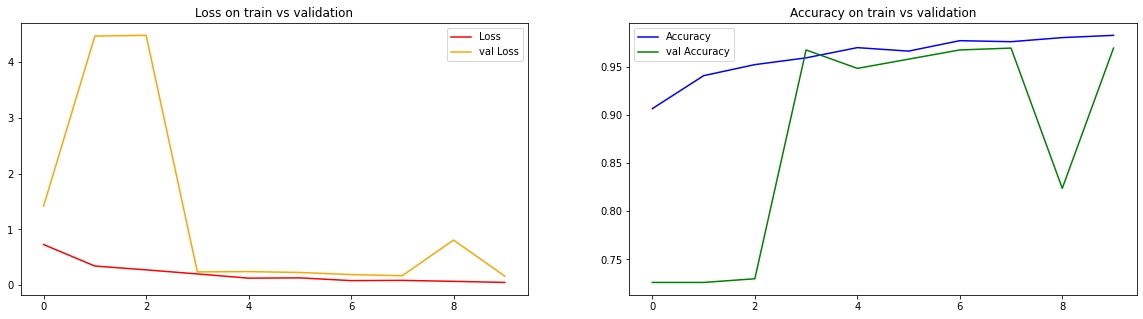

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_sr.epoch, y=history_sr.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_sr.epoch, y=history_sr.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_sr.epoch, y=history_sr.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_sr.epoch, y=history_sr.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

### Rotation + Zoom + Shear range

In [ ]:
datagen_true = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    shear_range = 10,
    validation_split = 0.1 
)

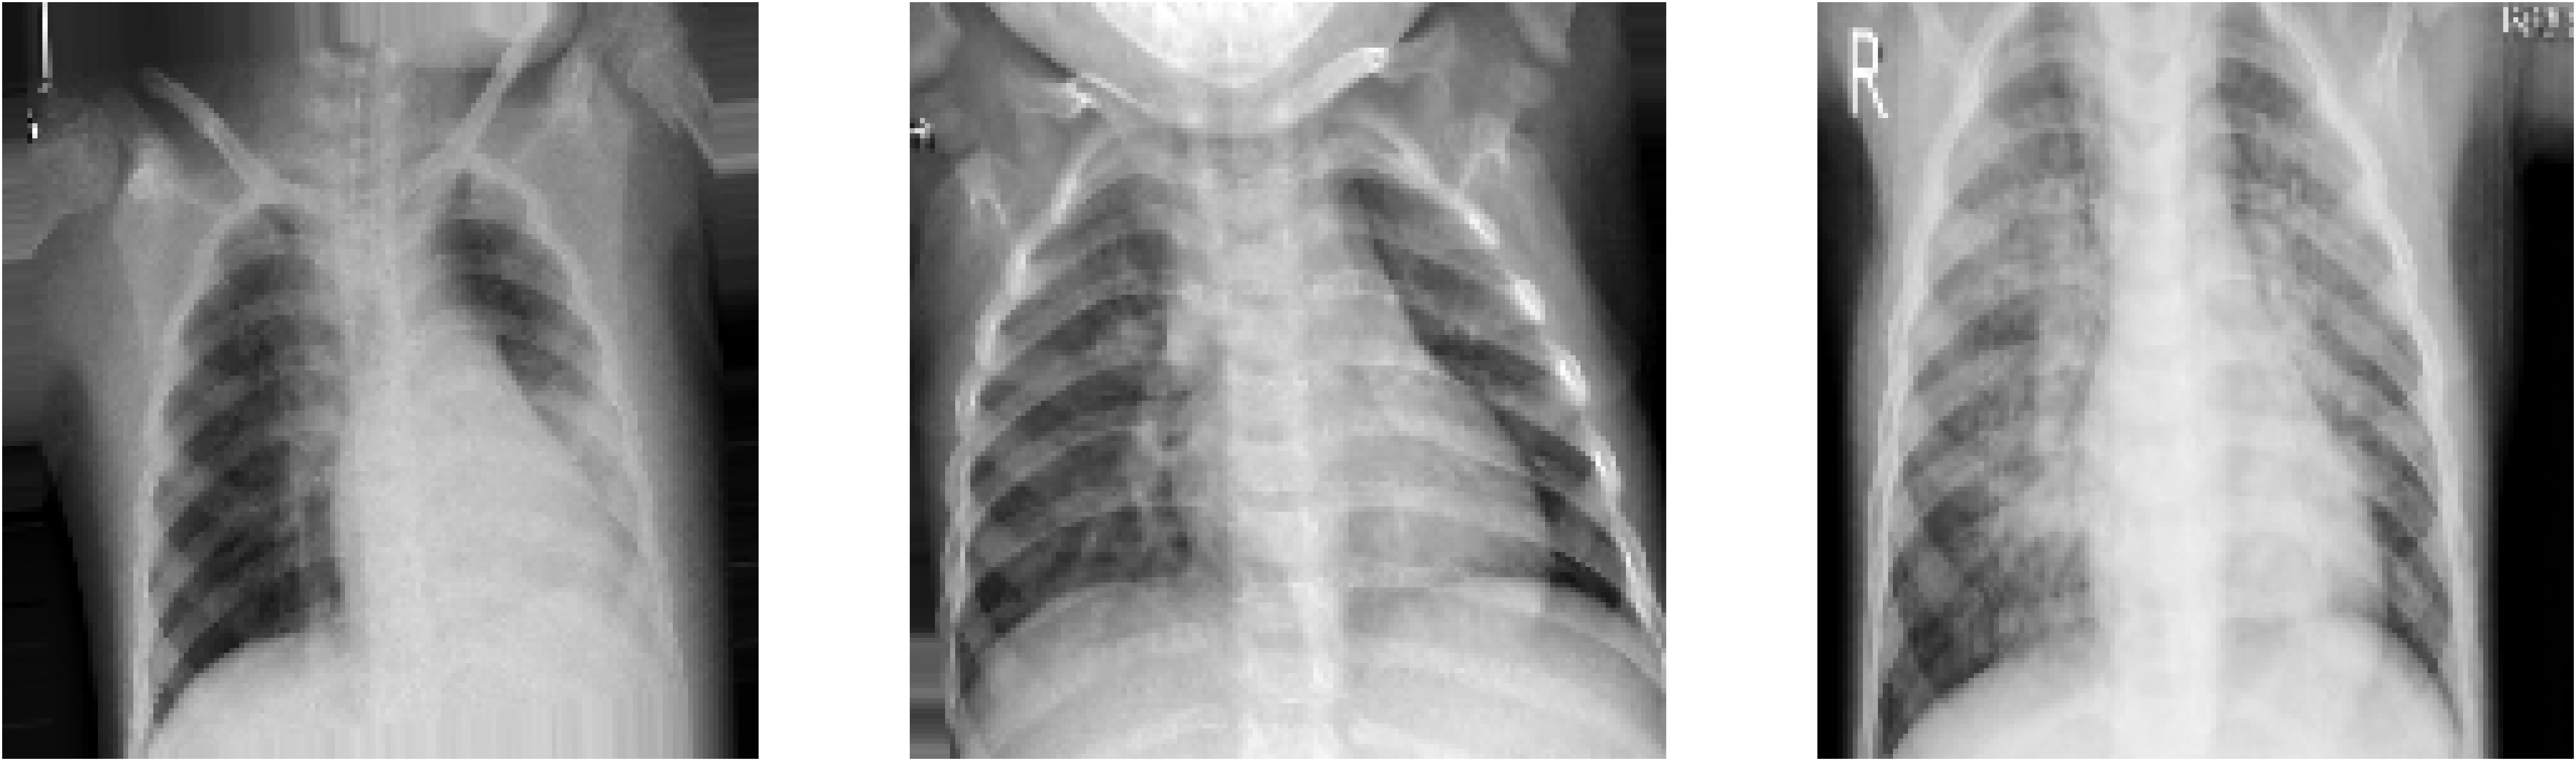

In [ ]:
# iterator
sample = X_train[1214:1217]

aug_iter = datagen_true.flow(sample)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(150,150))

# generate batch of images
for i in range(3):

	# convert to unsigned integers
	image = next(aug_iter)[0,:,:,0]
 
	# plot image
	ax[i].imshow(image, cmap="gray")
	ax[i].axis('off')

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_CNN_true = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_CNN_true = CNN_model.evaluate(X_test, y_test)
print(test_CNN_true)

Epoch 1/10
148/148 [==============================] - 14s 90ms/step - loss: 0.9158 - accuracy: 0.8859 - val_loss: 4.3070 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 86ms/step - loss: 0.4969 - accuracy: 0.9188 - val_loss: 6.6445 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2502 - accuracy: 0.9403 - val_loss: 0.2527 - val_accuracy: 0.9195
Epoch 4/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2925 - accuracy: 0.9339 - val_loss: 1.4697 - val_accuracy: 0.8448
Epoch 5/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2357 - accuracy: 0.9392 - val_loss: 0.7672 - val_accuracy: 0.8851
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1546 - accuracy: 0.9520 - val_loss: 0.6982 - val_accuracy: 0.8870
Epoch 7/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1707 - accuracy: 0.9439 - val_loss: 0.1201 - val_accuracy:

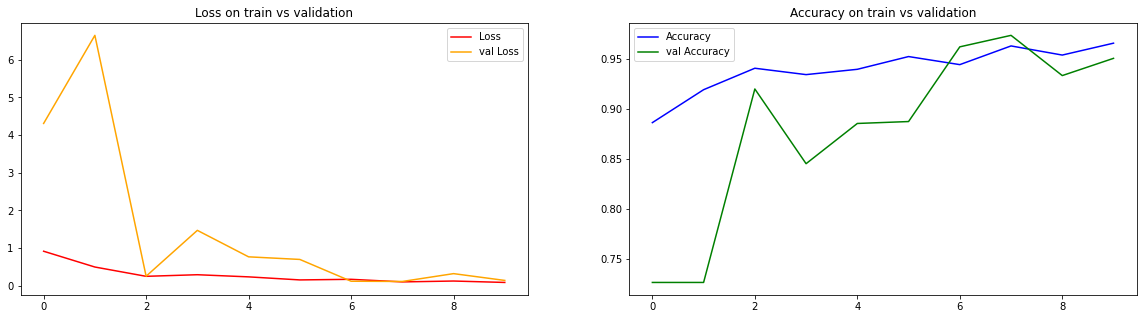

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_CNN_true.epoch, y=history_CNN_true.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_CNN_true.epoch, y=history_CNN_true.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_CNN_true.epoch, y=history_CNN_true.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_CNN_true.epoch, y=history_CNN_true.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

Pour la suite on gardera datagen_true comme ImageDataGenerator

## Comparaison d'initialisation différente des poids

### Méthode 1

cf Test des paramètres de la data augmentation : rotation + zoom + shear range

### Méthode 2

Dans le jeu d'entraînement il y a 74% d'image de la classe 1 (pneumonie) et 26% pour la classe 0 (normal) on utilisera donc ces valeurs pour initier les poids de cette façon :

In [ ]:
cl_w_2 = {0 : 0.74,
          1 : 0.26}

on réutilise CNN_model

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_w2 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_w_2,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_w2 = CNN_model.evaluate(X_test, y_test)
print(test_w2)

Epoch 1/10
148/148 [==============================] - 14s 88ms/step - loss: 0.3016 - accuracy: 0.8944 - val_loss: 5.2257 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1481 - accuracy: 0.9186 - val_loss: 9.0504 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1000 - accuracy: 0.9367 - val_loss: 6.9016 - val_accuracy: 0.7261
Epoch 4/10
148/148 [==============================] - 13s 87ms/step - loss: 0.0843 - accuracy: 0.9450 - val_loss: 0.3054 - val_accuracy: 0.9119
Epoch 5/10
148/148 [==============================] - 13s 87ms/step - loss: 0.0862 - accuracy: 0.9382 - val_loss: 2.7794 - val_accuracy: 0.7414
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.0797 - accuracy: 0.9384 - val_loss: 0.3072 - val_accuracy: 0.9349
Epoch 7/10
148/148 [==============================] - 13s 87ms/step - loss: 0.0474 - accuracy: 0.9575 - val_loss: 0.7728 - val_accuracy:

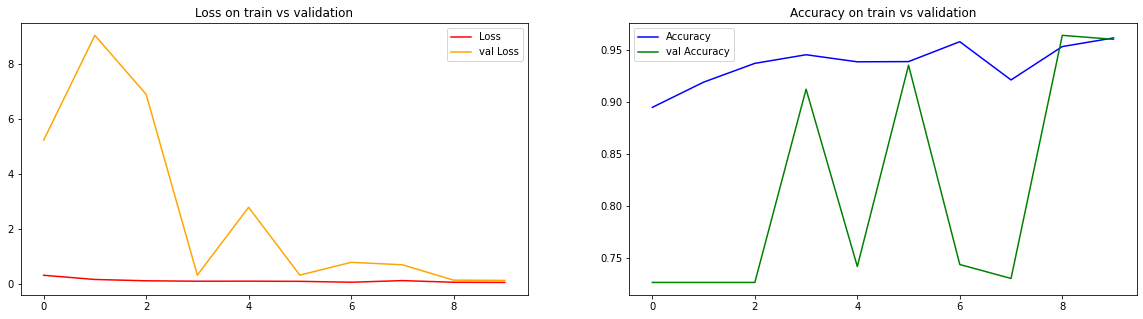

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_w2.epoch, y=history_w2.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_w2.epoch, y=history_w2.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_w2.epoch, y=history_w2.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_w2.epoch, y=history_w2.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

L'accuracy sur le test est similaire avec le résultat de la méthode 1.

La courbe des val loss est un tout petit peu moins stable et les courbes d'accuracy montre de plus grande variation que pour la méthode 1.

On décide donc de garder cette dernière pour l'initialisation des poids.

### Méthode 3

On décide de réessayer avec une initialisation aléatoire des poids.

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_w3 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_w3 = CNN_model.evaluate(X_test, y_test)
print(test_w3)

Epoch 1/10
148/148 [==============================] - 14s 89ms/step - loss: 0.7607 - accuracy: 0.8938 - val_loss: 4.8534 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 87ms/step - loss: 0.3086 - accuracy: 0.9305 - val_loss: 4.9052 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2434 - accuracy: 0.9416 - val_loss: 0.8489 - val_accuracy: 0.8161
Epoch 4/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2698 - accuracy: 0.9360 - val_loss: 1.3541 - val_accuracy: 0.8199
Epoch 5/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1640 - accuracy: 0.9564 - val_loss: 0.2189 - val_accuracy: 0.9598
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1735 - accuracy: 0.9471 - val_loss: 0.1729 - val_accuracy: 0.9540
Epoch 7/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1319 - accuracy: 0.9596 - val_loss: 0.3000 - val_accuracy:

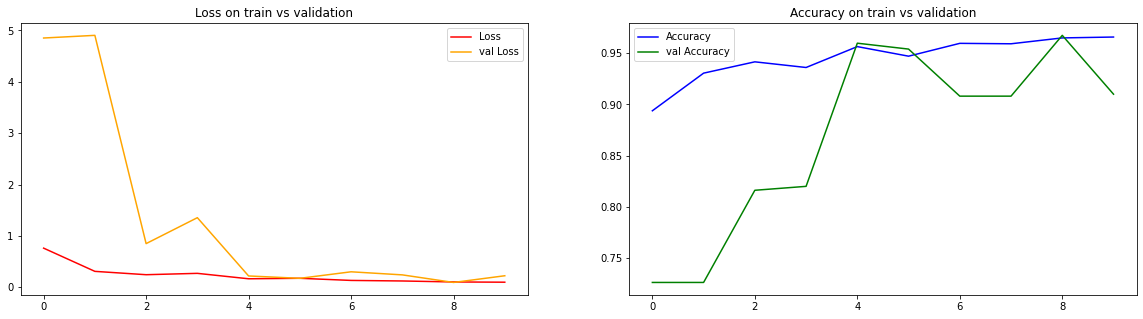

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_w3.epoch, y=history_w3.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_w3.epoch, y=history_w3.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_w3.epoch, y=history_w3.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_w3.epoch, y=history_w3.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

La valeur d'accuracy sur le test est bonne car elle est de 88.6%, les courbes de loss et d'accuracy sont également similaire à celle avec l'initialisation des poids. L'accuracy sur le test étant néanmoins plus faible qu'avec on décide de garder l'initialisation des poids.

## Intervalle de Confiance sur l'accuracy test

In [ ]:
res = []

for i in range(0, 10, 1):
##### Data generator for data augmentation
  augmented_data = ImageDataGenerator(
                  rotation_range = 10,
                  zoom_range = 0.1,
                  shear_range = 10,
                  validation_split = 0.1
)
  
##### Model compilation
  inputs = layers.Input(shape=(150, 150, 1 ))

  bc1 = block_conv(inputs, 16)

  bc2 = block_conv(bc1, 32)

  bc3 = block_conv(bc2, 64)

  bc4 = block_conv(bc3, 128)

  flat_1 = layers.Flatten()(bc4)
  dense_1 = layers.Dense(32)(flat_1)
  drop_1 = layers.Dropout(0.2)(dense_1)
  outputs = layers.Dense(1, activation='sigmoid')(drop_1)

  CNN_model = keras.Model(inputs, outputs)

  CNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

##### Fitting
  history_bas = CNN_model.fit(augmented_data.flow(x_train, y_train, subset="training"), batch_size = 32, epochs = 10, 
                            validation_data = augmented_data.flow(x_train, y_train, subset="validation"), class_weight = class_weight)
  
##### Evaluation
  eval = CNN_model.evaluate(x_test, y_test)
  res.append(eval[1])

In [ ]:
1.65*(stdev(res)/((len(res)**(1/2))))*100

Lors de l'éxecution on a obtenu cette intervalle :
$90.4 \pm 1.9$

## Variation du Learning Rate

jusqu'à présent on laissait le learning rate de base soit 0.001.

Nous allons faire varier cette valeur et observer les résultats.

On utilisera le modèle : CNN_model et l'ImageDataGenerator : datagen_true

### Learning Rate : 0.001

cf Test des paramètres de la data augmentation : rotation + zoom + shear range

### Learning Rate : 0.1

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.1),
    metrics=["accuracy"]
)

history_LR01 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_LR01 = CNN_model.evaluate(X_test, y_test)
print(test_LR01)

Epoch 1/10
148/148 [==============================] - 14s 88ms/step - loss: 9.3606 - accuracy: 0.8102 - val_loss: 1.0420 - val_accuracy: 0.6801
Epoch 2/10
148/148 [==============================] - 13s 87ms/step - loss: 0.3287 - accuracy: 0.8921 - val_loss: 0.7832 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 86ms/step - loss: 1.6809 - accuracy: 0.8517 - val_loss: 0.2826 - val_accuracy: 0.9100
Epoch 4/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2881 - accuracy: 0.9020 - val_loss: 0.1752 - val_accuracy: 0.9272
Epoch 5/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2805 - accuracy: 0.9112 - val_loss: 0.4883 - val_accuracy: 0.8563
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2165 - accuracy: 0.9282 - val_loss: 0.1930 - val_accuracy: 0.9349
Epoch 7/10
148/148 [==============================] - 13s 87ms/step - loss: 2.3435 - accuracy: 0.8657 - val_loss: 234.2781 - val_accurac

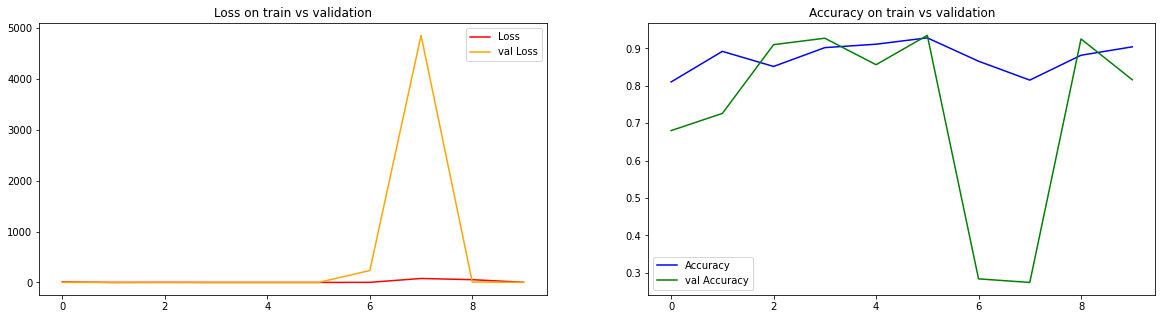

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_LR01.epoch, y=history_LR01.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_LR01.epoch, y=history_LR01.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_LR01.epoch, y=history_LR01.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_LR01.epoch, y=history_LR01.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

L'accuracy sur le test est de 0.80, soit 10% de moins qu'avec le Learning Rate de base. Si on regarde les courbes pour les loss et l'accuracy sur le jeu de train et de validation, on voit que les loss stagnait (ce qui n'est pas bon) avant une explosion sur le jeu de validation.

### Learning Rate : 0.01

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.01),
    metrics=["accuracy"]
)

history_LR001 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_LR001 = CNN_model.evaluate(X_test, y_test)
print(test_LR001)

Epoch 1/10
148/148 [==============================] - 14s 88ms/step - loss: 2.6308 - accuracy: 0.8670 - val_loss: 0.6984 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2001 - accuracy: 0.9280 - val_loss: 1.6213 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1792 - accuracy: 0.9335 - val_loss: 0.4491 - val_accuracy: 0.8352
Epoch 4/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1694 - accuracy: 0.9367 - val_loss: 0.6953 - val_accuracy: 0.8352
Epoch 5/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1675 - accuracy: 0.9452 - val_loss: 1.9579 - val_accuracy: 0.7356
Epoch 6/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1832 - accuracy: 0.9346 - val_loss: 2.6700 - val_accuracy: 0.5134
Epoch 7/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1771 - accuracy: 0.9411 - val_loss: 0.1365 - val_accuracy:

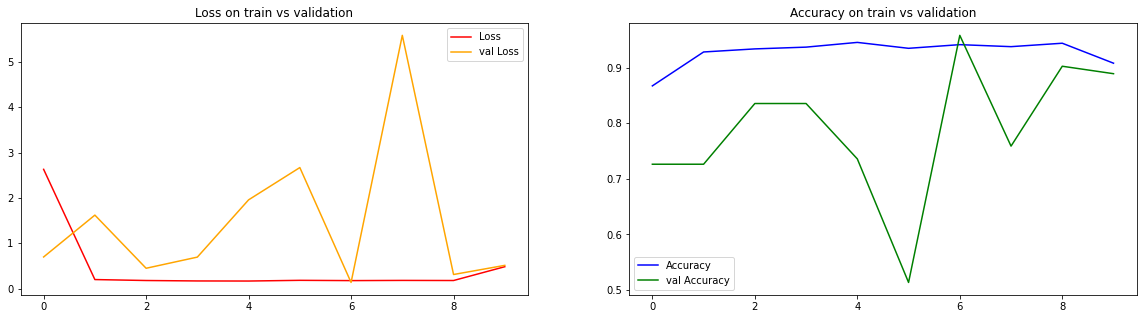

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_LR001.epoch, y=history_LR001.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_LR001.epoch, y=history_LR001.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_LR001.epoch, y=history_LR001.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_LR001.epoch, y=history_LR001.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

Le résultat de l'accuracy sur le jeu de test est plus faible que pour un LR de 0.1 et 0.001. On voit que les courbes ne sont pas stable du tout la loss et l'accuracy varie beacoup, tandis qu'idéalement elle devrait respectivement décroître et croître avant d'atteindre un plateau proche de la valeur pour le jeu train.

### Learning Rate : 0.0001

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.01),
    metrics=["accuracy"]
)

history_LR00001 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_LR00001 = CNN_model.evaluate(X_test, y_test)
print(test_LR00001)

Epoch 1/10
148/148 [==============================] - 14s 89ms/step - loss: 2.7630 - accuracy: 0.8670 - val_loss: 0.4094 - val_accuracy: 0.7931
Epoch 2/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2536 - accuracy: 0.9186 - val_loss: 0.9258 - val_accuracy: 0.7280
Epoch 3/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1866 - accuracy: 0.9350 - val_loss: 0.1925 - val_accuracy: 0.9330
Epoch 4/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2100 - accuracy: 0.9288 - val_loss: 1.2118 - val_accuracy: 0.7318
Epoch 5/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1868 - accuracy: 0.9348 - val_loss: 0.1948 - val_accuracy: 0.9291
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2837 - accuracy: 0.9180 - val_loss: 0.7059 - val_accuracy: 0.7529
Epoch 7/10
148/148 [==============================] - 13s 87ms/step - loss: 0.3942 - accuracy: 0.9110 - val_loss: 0.9192 - val_accuracy:

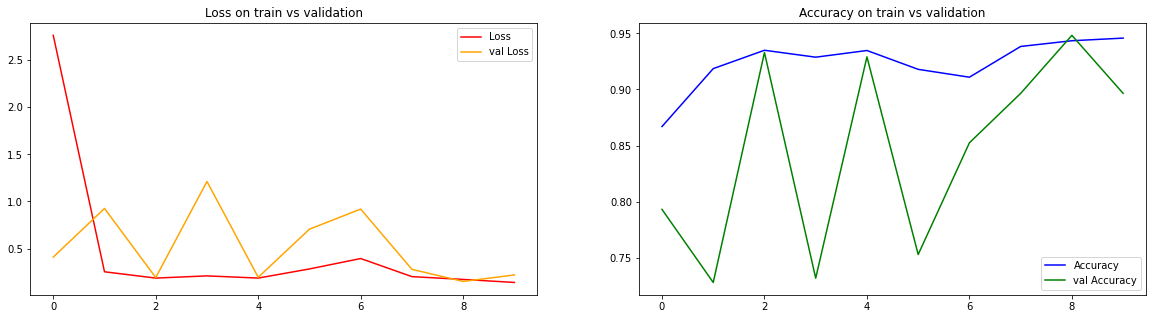

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_LR00001.epoch, y=history_LR00001.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_LR00001.epoch, y=history_LR00001.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_LR00001.epoch, y=history_LR00001.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_LR00001.epoch, y=history_LR00001.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

Encore une fois la valeur de l'accuracy sur le jeu de test est inférieure à ce qu'on obtiens avec le learning rate de 0.001.

Les courbes de val loss et val accuracy montre également plus de variation.

### Learning Rate : 0.00001

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.01),
    metrics=["accuracy"]
)

history_LR000001 = CNN_model.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_LR000001 = CNN_model.evaluate(X_test, y_test)
print(test_LR000001)

Epoch 1/10
148/148 [==============================] - 14s 89ms/step - loss: 2.1745 - accuracy: 0.8874 - val_loss: 0.8396 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1722 - accuracy: 0.9371 - val_loss: 1.6898 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1660 - accuracy: 0.9373 - val_loss: 1.3331 - val_accuracy: 0.7261
Epoch 4/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1688 - accuracy: 0.9388 - val_loss: 0.1983 - val_accuracy: 0.9253
Epoch 5/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1779 - accuracy: 0.9428 - val_loss: 0.1418 - val_accuracy: 0.9579
Epoch 6/10
148/148 [==============================] - 13s 87ms/step - loss: 0.2787 - accuracy: 0.9248 - val_loss: 0.2516 - val_accuracy: 0.8985
Epoch 7/10
148/148 [==============================] - 13s 87ms/step - loss: 0.1728 - accuracy: 0.9382 - val_loss: 0.1434 - val_accuracy:

Ce pas semble trop petit, la valeur d'accuracy obtenue sur le jeu test est de 0.625 qui correspond également à la proportion de pneumonie dans le jeu test, ce qui signifie qu'il classe toutes les images en pneumonie, comme le montre la matrice de confusion suivante :

In [ ]:
prediction = CNN_model.predict(X_test)
y_pred = np.round(prediction,0)
print(confusion_matrix(y_test, y_pred))

[[  0 234]
 [  0 390]]


Pour la suite on va donc garder le même Learing Rate que d'habitude, celui de base valant : 0.001

## Modification de l'architecture

#### Deux Conv2D avant la Batch normalization

In [ ]:
def doubleblock_conv(input, filters):
  x = layers.Conv2D(filters, 3, activation='relu')(input)
  x = layers.Conv2D(filters, 3, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(2)(x)
  return(x)

In [ ]:
inputs = layers.Input(shape=(150, 150, 1 ))

bc1 = doubleblock_conv(inputs, 16)

bc2 = doubleblock_conv(bc1, 32)

bc3 = doubleblock_conv(bc2, 64)

bc4 = doubleblock_conv(bc3, 128)

flat_1 = layers.Flatten()(bc4)
dense_1 = layers.Dense(32)(flat_1)
drop_1 = layers.Dropout(0.2)(dense_1)
outputs = layers.Dense(1, activation='sigmoid')(drop_1)

model_DC = keras.Model(inputs, outputs)

print(model_DC.summary())

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 148, 148, 16)      160       
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 146, 146, 16)      2320      
_________________________________________________________________
batch_normalization_79 (Batc (None, 146, 146, 16)      64        
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 71, 71, 32)        4640      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 69, 69, 32)        924

On voit que le nombre de paramètre a légèrement augmenter, la différence ce fait sur la profondeur du réseau.

In [ ]:
model_DC.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_DC = model_DC.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_DC = model_DC.evaluate(X_test, y_test)
print(test_DC)

Epoch 1/10
148/148 [==============================] - 16s 98ms/step - loss: 0.4619 - accuracy: 0.8808 - val_loss: 3.6974 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 15s 98ms/step - loss: 0.2838 - accuracy: 0.9144 - val_loss: 6.8832 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 14s 97ms/step - loss: 0.2069 - accuracy: 0.9288 - val_loss: 1.6316 - val_accuracy: 0.7433
Epoch 4/10
148/148 [==============================] - 15s 99ms/step - loss: 0.1693 - accuracy: 0.9363 - val_loss: 0.7676 - val_accuracy: 0.8352
Epoch 5/10
148/148 [==============================] - 15s 98ms/step - loss: 0.1516 - accuracy: 0.9448 - val_loss: 0.2751 - val_accuracy: 0.8927
Epoch 6/10
148/148 [==============================] - 15s 98ms/step - loss: 0.1415 - accuracy: 0.9456 - val_loss: 0.1849 - val_accuracy: 0.9291
Epoch 7/10
148/148 [==============================] - 15s 98ms/step - loss: 0.1468 - accuracy: 0.9452 - val_loss: 0.1509 - val_accuracy:

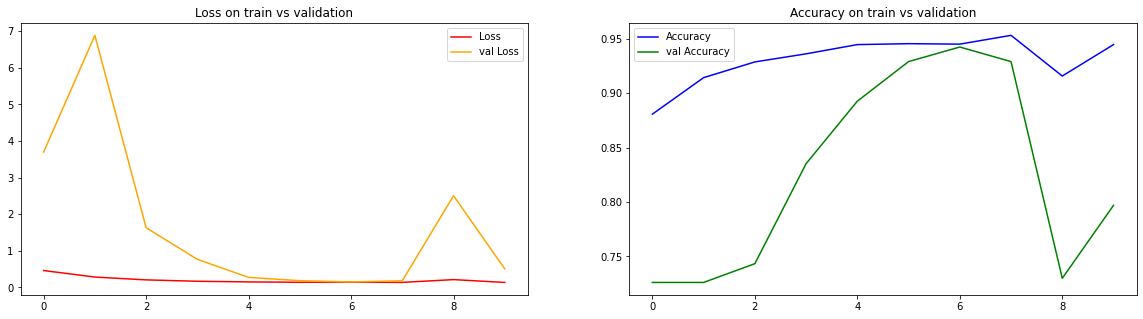

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_DC.epoch, y=history_DC.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_DC.epoch, y=history_DC.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_DC.epoch, y=history_DC.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_DC.epoch, y=history_DC.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

La valeur d'accuracy sur le jeu de test est relativement bonne 0.85. La val loss a bien diminue avant de remonter un petit peu.

### Augmentation du Kernel size

In [ ]:
def block_kernel(input, filters, kernel):
  x = layers.Conv2D(filters, kernel, activation='relu')(input)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling2D(2)(x)
  return(x)

In [ ]:
inputs = layers.Input(shape=(150, 150, 1 ))

bc1 = block_kernel(inputs, 16, 7)

bc2 = block_kernel(bc1, 32, 7)

bc3 = block_kernel(bc2, 64, 7)

bc4 = block_kernel(bc3, 128, 7)

flat_1 = layers.Flatten()(bc4)
dense_1 = layers.Dense(32)(flat_1)
drop_1 = layers.Dropout(0.2)(dense_1)
outputs = layers.Dense(1, activation='sigmoid')(drop_1)

model_K1 = keras.Model(inputs, outputs)

print(model_K1.summary())

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 144, 144, 16)      800       
_________________________________________________________________
batch_normalization_96 (Batc (None, 144, 144, 16)      64        
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 72, 72, 16)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 66, 66, 32)        25120     
_________________________________________________________________
batch_normalization_97 (Batc (None, 66, 66, 32)        128       
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 33, 33, 32)        0  

In [ ]:
model_K1.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_K1 = model_K1.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_K1 = model_K1.evaluate(X_test, y_test)
print(test_K1)

Epoch 1/10
148/148 [==============================] - 14s 88ms/step - loss: 0.4352 - accuracy: 0.8693 - val_loss: 1.7254 - val_accuracy: 0.7261
Epoch 2/10
148/148 [==============================] - 13s 86ms/step - loss: 0.2612 - accuracy: 0.9020 - val_loss: 2.5749 - val_accuracy: 0.7261
Epoch 3/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1869 - accuracy: 0.9263 - val_loss: 5.7346 - val_accuracy: 0.7261
Epoch 4/10
148/148 [==============================] - 13s 86ms/step - loss: 0.1800 - accuracy: 0.9314 - val_loss: 0.4020 - val_accuracy: 0.7969
Epoch 5/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1998 - accuracy: 0.9299 - val_loss: 0.2469 - val_accuracy: 0.9004
Epoch 6/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1445 - accuracy: 0.9428 - val_loss: 1.1935 - val_accuracy: 0.5307
Epoch 7/10
148/148 [==============================] - 13s 85ms/step - loss: 0.1346 - accuracy: 0.9473 - val_loss: 0.2974 - val_accuracy:

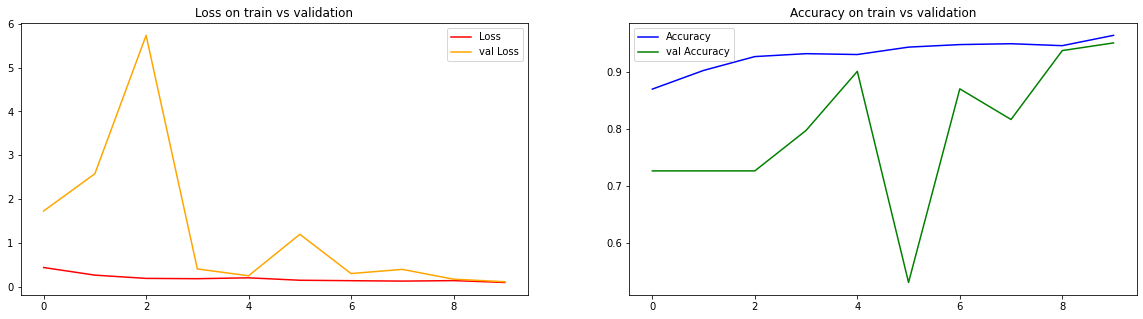

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_K1.epoch, y=history_K1.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_K1.epoch, y=history_K1.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_K1.epoch, y=history_K1.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_K1.epoch, y=history_K1.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

### Deux Conv avant la Batch normalization + variation du kernel size

Ce modèle correspond à un modèle vu sur kaggle, sur lequel nous avions effectuer des test. Il fait partie des 2 modèles que nous avons prit sur kaggle.

In [ ]:
inputs = layers.Input(shape=(150, 150, 1 ))

bc1 = doubleblock_kernel(inputs, 16, 7)

bc2 = doubleblock_kernel(bc1, 32, 5)

bc3 = doubleblock_kernel(bc2, 64, 3)

flat_1 = layers.Flatten()(bc3)
dense_1 = layers.Dense(32)(flat_1)
drop_1 = layers.Dropout(0.2)(dense_1)
outputs = layers.Dense(1, activation='sigmoid')(drop_1)

model_DK = keras.Model(inputs, outputs)

print(model_DK.summary())

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 144, 144, 16)      800       
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 138, 138, 32)      25120     
_________________________________________________________________
batch_normalization_83 (Batc (None, 138, 138, 32)      128       
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 69, 69, 32)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 65, 65, 32)        25632     
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 61, 61, 64)        512

On constate que ce modèle possède 3 fois plus de paramètres que CNN_model, et plus de 2 fois plus que model_DC.

In [ ]:
model_DK.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_DK = model_DK.fit(
    datagen_true.flow(X_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight=cl_weights,
    validation_data= datagen_true.flow(X_train, y_train, subset="validation")
)

test_DK = model_DK.evaluate(X_test, y_test)
print(test_DK)

Epoch 1/10
148/148 [==============================] - 23s 132ms/step - loss: 1.9380 - accuracy: 0.8604 - val_loss: 0.9414 - val_accuracy: 0.8640
Epoch 2/10
148/148 [==============================] - 19s 127ms/step - loss: 1.4125 - accuracy: 0.8840 - val_loss: 0.6797 - val_accuracy: 0.9023
Epoch 3/10
148/148 [==============================] - 19s 126ms/step - loss: 1.0660 - accuracy: 0.8897 - val_loss: 1.4730 - val_accuracy: 0.8410
Epoch 4/10
148/148 [==============================] - 19s 127ms/step - loss: 0.6423 - accuracy: 0.9088 - val_loss: 0.5111 - val_accuracy: 0.9234
Epoch 5/10
148/148 [==============================] - 19s 127ms/step - loss: 0.3526 - accuracy: 0.9239 - val_loss: 0.2516 - val_accuracy: 0.9349
Epoch 6/10
148/148 [==============================] - 19s 127ms/step - loss: 0.2299 - accuracy: 0.9392 - val_loss: 0.1628 - val_accuracy: 0.9406
Epoch 7/10
148/148 [==============================] - 19s 128ms/step - loss: 0.1955 - accuracy: 0.9377 - val_loss: 0.1929 - val_ac

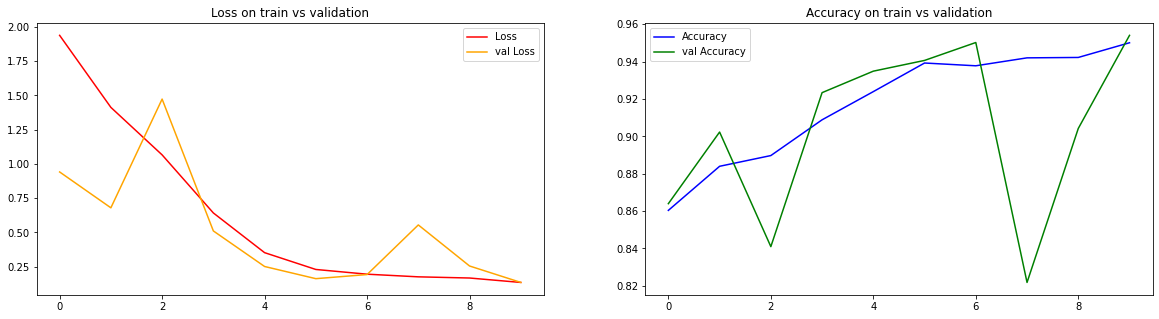

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
seaborn.lineplot(x=history_DK.epoch, y=history_DK.history['loss'], color='red', label='Loss')
seaborn.lineplot(x=history_DK.epoch, y=history_DK.history['val_loss'], color='orange', label='val Loss')
plt.title('Loss on train vs validation')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
seaborn.lineplot(x=history_DK.epoch, y=history_DK.history['accuracy'], color='blue', label='Accuracy')
seaborn.lineplot(x=history_DK.epoch, y=history_DK.history['val_accuracy'], color='green', label='val Accuracy')
plt.title('Accuracy on train vs validation')
plt.legend(loc='best')

plt.show()

# Transfert learning

## VGG16

In [ ]:
x_Gtrain = X_train[:,:,:,0]
x_Gtest = X_test[:,:,:,0]

rgb_x_train = np.repeat(x_Gtrain[..., np.newaxis], 3, -1)
rgb_x_test = np.repeat(x_Gtest[..., np.newaxis], 3, -1)

print(rgb_x_train.shape)
print(rgb_x_test.shape)

(5228, 150, 150, 3)
(624, 150, 150, 3)


In [ ]:
inputs = layers.Input(shape=(150, 150, 3))
vgg_model = VGG16(include_top= False,
                     weights = "imagenet",
)
vgg_model.trainable = False

base = vgg_model(inputs, training = False)
#avg_1 = layers.GlobalAveragePooling2D()(base)
#drop_1 = layers.Dropout(0.5)(avg_1)
#dense_1 = layers.Dense(32)(drop_1)
flat1 = layers.Flatten()(base)
outputs = layers.Dense(1, activation='sigmoid')(flat1)

TL_VGG = keras.Model(inputs, outputs)

TL_VGG.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_26 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 8193      
Total params: 14,722,881
Trainable params: 8,193
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
TL_VGG.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_VGG = TL_VGG.fit(
    datagen_true.flow(rgb_x_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight = cl_weights,
    validation_data= datagen_true.flow(rgb_x_train, y_train, subset="validation")
)

test_VGG = TL_VGG.evaluate(rgb_x_test, y_test)
print(test_VGG)

Epoch 1/10
148/148 [==============================] - 42s 247ms/step - loss: 0.2563 - accuracy: 0.8944 - val_loss: 0.1547 - val_accuracy: 0.9368
Epoch 2/10
148/148 [==============================] - 34s 228ms/step - loss: 0.1541 - accuracy: 0.9377 - val_loss: 0.1571 - val_accuracy: 0.9291
Epoch 3/10
148/148 [==============================] - 34s 230ms/step - loss: 0.1365 - accuracy: 0.9460 - val_loss: 0.1305 - val_accuracy: 0.9464
Epoch 4/10
148/148 [==============================] - 34s 230ms/step - loss: 0.1265 - accuracy: 0.9501 - val_loss: 0.1177 - val_accuracy: 0.9464
Epoch 5/10
148/148 [==============================] - 34s 232ms/step - loss: 0.1161 - accuracy: 0.9541 - val_loss: 0.1434 - val_accuracy: 0.9387
Epoch 6/10
148/148 [==============================] - 35s 236ms/step - loss: 0.1165 - accuracy: 0.9554 - val_loss: 0.1210 - val_accuracy: 0.9444
Epoch 7/10
148/148 [==============================] - 37s 248ms/step - loss: 0.1102 - accuracy: 0.9541 - val_loss: 0.1102 - val_ac

## ResNet50V2

In [ ]:
inputs = layers.Input(shape=(150, 150, 3))
RNV2_model = ResNet50V2(include_top= False,
                     weights = "imagenet",
)
RNV2_model.trainable = False

base = RNV2_model(inputs, training = False)
#avg_1 = layers.GlobalAveragePooling2D()(base)
#drop_1 = layers.Dropout(0.5)(avg_1)
#dense_1 = layers.Dense(32)(drop_1)
flat1 = layers.Flatten()(base)
outputs = layers.Dense(1, activation='sigmoid')(flat1)

TL_RNV2 = keras.Model(inputs, outputs)

TL_RNV2.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
flatten_27 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 51201     
Total params: 23,616,001
Trainable params: 51,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
TL_RNV2.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_RNV2 = TL_RNV2.fit(
    datagen_true.flow(rgb_x_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight = cl_weights,
    validation_data= datagen_true.flow(rgb_x_train, y_train, subset="validation")
)

test_RNV2 = TL_RNV2.evaluate(rgb_x_test, y_test)
print(test_RNV2)

Epoch 1/10
148/148 [==============================] - 52s 235ms/step - loss: 0.5514 - accuracy: 0.9159 - val_loss: 0.5359 - val_accuracy: 0.9425
Epoch 2/10
148/148 [==============================] - 36s 245ms/step - loss: 0.3417 - accuracy: 0.9475 - val_loss: 0.3293 - val_accuracy: 0.9483
Epoch 3/10
148/148 [==============================] - 36s 245ms/step - loss: 0.3008 - accuracy: 0.9556 - val_loss: 0.2553 - val_accuracy: 0.9636
Epoch 4/10
148/148 [==============================] - 35s 235ms/step - loss: 0.2474 - accuracy: 0.9622 - val_loss: 0.3854 - val_accuracy: 0.9598
Epoch 5/10
148/148 [==============================] - 33s 221ms/step - loss: 0.2725 - accuracy: 0.9637 - val_loss: 0.4334 - val_accuracy: 0.9559
Epoch 6/10
148/148 [==============================] - 33s 221ms/step - loss: 0.2499 - accuracy: 0.9690 - val_loss: 0.3632 - val_accuracy: 0.9598
Epoch 7/10
148/148 [==============================] - 33s 220ms/step - loss: 0.2099 - accuracy: 0.9677 - val_loss: 0.2430 - val_ac

## InceptionV3

In [ ]:
inputs = layers.Input(shape=(150, 150, 3))
InV3_model = InceptionV3(include_top= False,
                     weights = "imagenet",
)
InV3_model.trainable = False

base = InV3_model(inputs, training = False)
#avg_1 = layers.GlobalAveragePooling2D()(base)
#drop_1 = layers.Dropout(0.5)(avg_1)
#dense_1 = layers.Dense(32)(drop_1)
flat1 = layers.Flatten()(base)
outputs = layers.Dense(1, activation='sigmoid')(flat1)

TL_InV3 = keras.Model(inputs, outputs)

TL_InV3.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, None, None, 2048)  21802784  
_________________________________________________________________
flatten_28 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 18433     
Total params: 21,821,217
Trainable params: 18,433
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
TL_InV3.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_InV3 = TL_InV3.fit(
    datagen_true.flow(rgb_x_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight = cl_weights,
    validation_data= datagen_true.flow(rgb_x_train, y_train, subset="validation")
)

test_InV3 = TL_InV3.evaluate(rgb_x_test, y_test)
print(test_InV3)

Epoch 1/10
148/148 [==============================] - 40s 228ms/step - loss: 0.7237 - accuracy: 0.8674 - val_loss: 0.2784 - val_accuracy: 0.9406
Epoch 2/10
148/148 [==============================] - 31s 209ms/step - loss: 0.2911 - accuracy: 0.9335 - val_loss: 0.2100 - val_accuracy: 0.9483
Epoch 3/10
148/148 [==============================] - 32s 216ms/step - loss: 0.2915 - accuracy: 0.9299 - val_loss: 0.1909 - val_accuracy: 0.9540
Epoch 4/10
148/148 [==============================] - 32s 219ms/step - loss: 0.3050 - accuracy: 0.9318 - val_loss: 0.2985 - val_accuracy: 0.9330
Epoch 5/10
148/148 [==============================] - 33s 219ms/step - loss: 0.2203 - accuracy: 0.9452 - val_loss: 0.4906 - val_accuracy: 0.8889
Epoch 6/10
148/148 [==============================] - 33s 220ms/step - loss: 0.2401 - accuracy: 0.9448 - val_loss: 0.1828 - val_accuracy: 0.9579
Epoch 7/10
148/148 [==============================] - 35s 239ms/step - loss: 0.2042 - accuracy: 0.9503 - val_loss: 0.1793 - val_ac

## DenseNet201

In [ ]:
inputs = layers.Input(shape=(150, 150, 3))
DN201_model = DenseNet201(include_top= False,
                     weights = "imagenet",
)
DN201_model.trainable = False

base = DN201_model(inputs, training = False)
#avg_1 = layers.GlobalAveragePooling2D()(base)
#drop_1 = layers.Dropout(0.5)(avg_1)
#dense_1 = layers.Dense(32)(drop_1)
flat1 = layers.Flatten()(base)
outputs = layers.Dense(1, activation='sigmoid')(flat1)

TL_DN201 = keras.Model(inputs, outputs)

TL_DN201.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
flatten_2 (Flatten)          (None, 30720)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 30721     
Total params: 18,352,705
Trainable params: 30,721
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
TL_DN201.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

history_DN201 = TL_DN201.fit(
    datagen_true.flow(rgb_x_train, y_train, batch_size=32, subset="training"),
    epochs=10, class_weight = cl_weights,
    validation_data= datagen_true.flow(rgb_x_train, y_train, subset="validation")
)

test_DN201 = TL_DN201.evaluate(rgb_x_test, y_test)
print(test_DN201)

Epoch 1/10
148/148 [==============================] - 491s 3s/step - loss: 0.2249 - accuracy: 0.9248 - val_loss: 0.1313 - val_accuracy: 0.9483
Epoch 2/10
148/148 [==============================] - 499s 3s/step - loss: 0.1615 - accuracy: 0.9492 - val_loss: 0.0973 - val_accuracy: 0.9655
Epoch 3/10
148/148 [==============================] - 500s 3s/step - loss: 0.1617 - accuracy: 0.9490 - val_loss: 0.1381 - val_accuracy: 0.9598
Epoch 4/10
148/148 [==============================] - 500s 3s/step - loss: 0.1321 - accuracy: 0.9605 - val_loss: 0.1955 - val_accuracy: 0.9502
Epoch 5/10
148/148 [==============================] - 497s 3s/step - loss: 0.1884 - accuracy: 0.9547 - val_loss: 0.1204 - val_accuracy: 0.9598
Epoch 6/10
148/148 [==============================] - 498s 3s/step - loss: 0.1286 - accuracy: 0.9618 - val_loss: 0.1838 - val_accuracy: 0.9483
Epoch 7/10
148/148 [==============================] - 496s 3s/step - loss: 0.1100 - accuracy: 0.9688 - val_loss: 0.0891 - val_accuracy: 0.9674

# Comparaison

Model_TF = CNN_model

In [ ]:
df_Recap = pd.DataFrame(columns=["Accuracy test","Sensiti.(%)","Specifi.(%)","Number of Parameters"],
                     index=["Model_TF", "Model_DC","Model_K1","Model_DK","TL_VGG",
                            "TL_ResNet50V2","TL_InceptionV3","TL_DenseNet201"],
                     data=[[0.924, (363/390)*100, (214/234)*100, "298 881"],
                           [0.846, (387/390)*100, (141/234)*100, "396 657"],
                           [0.868, (385/390)*100, (157/234)*100, "565 761"],
                           [0.873, (385/390)*100, (160/234)*100, "906 785"],
                           [0.877, (341/390)*100, (206/234)*100, "14 722 881"],
                           [0.888, (364/390)*100, (190/234)*100, "23 616 001"],
                           [0.859, (372/390)*100, (164/234)*100, "21 821 217"],
                           [0.881, (366/390)*100, (184/234)*100, "18 352 705"],])

In [ ]:
print(df_Recap)

                Accuracy test  Sensiti.(%)  Specifi.(%) Number of Parameters
Model_TF                0.924    93.076923    91.452991              298 881
Model_DC                0.846    99.230769    60.256410              396 657
Model_K1                0.868    98.717949    67.094017              565 761
Model_DK                0.873    98.717949    68.376068              906 785
TL_VGG                  0.877    87.435897    88.034188           14 722 881
TL_ResNet50V2           0.888    93.333333    81.196581           23 616 001
TL_InceptionV3          0.859    95.384615    70.085470           21 821 217
TL_DenseNet201          0.881    93.846154    78.632479           18 352 705


# Observation résultat

Pour cette partie on réutilise les meilleur poids obtenu avec CNN_model

In [ ]:
CNN_model.load_weights("./cnn_xray_pneumo.h5")

In [ ]:
CNN_model.compile(
    loss="binary_crossentropy",
    optimizer= keras.optimizers.Adam(learning_rate= 0.001),
    metrics=["accuracy"]
)

In [ ]:
CNN_model.evaluate(X_test, y_test)

20/20 [==============================] - 4s 171ms/step - loss: 0.1959 - accuracy: 0.9247


[0.1959124356508255, 0.9246794581413269]

In [ ]:
prediction = CNN_model.predict(X_test)
y_pred = np.round(prediction,0)
print(confusion_matrix(y_test, y_pred))

[[214  20]
 [ 27 363]]


In [ ]:
cm_y_pred = confusion_matrix(y_test, y_pred)

In [ ]:
df_pred = pd.DataFrame(cm_y_pred , index = ['0','1'] , columns = ['0','1'])

In [ ]:
df_pred

,0,1
0,214,20
1,27,363


In [ ]:
y_pred[:15]

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
liste_pred = []
for elem in y_pred:
  liste_pred.append(elem[0])

In [ ]:
arr_pred = np.asarray(liste_pred)

In [ ]:
arr_y = np.column_stack((y_test, arr_pred))

In [ ]:
correct = []
incorrect = []
for i in range(len(y_test)):
  if arr_y[i][0] == arr_y[i][1]:
    correct.append(i)
  else:
    incorrect.append(i)

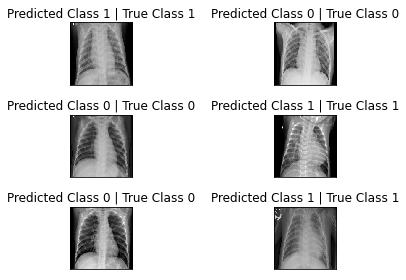

In [ ]:
i = 0
for c in correct[7:13]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {} | True Class {}".format(int(y_pred[c]), y_test[c]))
    plt.tight_layout()
    i += 1

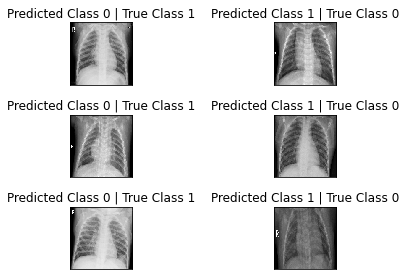

In [ ]:
i = 0
for c in incorrect[7:13]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {} | True Class {}".format(int(y_pred[c]), y_test[c]))
    plt.tight_layout()
    i += 1